<a href="https://colab.research.google.com/github/deniseiras/Forex_RNN/blob/main/Forex_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Rede RNN (LSTM) - Moeda

Denis M. A. Eiras
Atualizado: 30/08/2023

O notebook objetiva fazer a predição das moedas EURO e DÓLAR dos últimos 10 dias e comparar com os dados observados. Ainda, fazer a predição futura dos próximos 10 dias.

O dataset é disponibilizado através do uso da API yahoo finance.

Tempo aproximado de execução de xxx minutos

## Inicialização das bibliotecas e parâmetros gerais


In [ ]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import LSTM, Input, Dropout, Dense, RepeatVector, TimeDistributed, Conv1D, Flatten, MaxPooling1D, \
  BatchNormalization, Activation
from keras.regularizers import l2
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import pickle
#import glob
!pip install yfinance
import yfinance as yf
from IPython import display
import sys
import warnings
from time import time
from datetime import datetime, timedelta
from random import uniform

warnings.filterwarnings('ignore')
print("")
print("Python version:")
print (sys.version)
print("\nTensorflow version:")
print(tf.__version__)
print('')



Python version:
3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]

Tensorflow version:
2.12.0



In [ ]:
eurobrl = "EURBRL=X"
usdbrl = "USDBRL=X"
msft = yf.Ticker( eurobrl)

# get stock info
print(msft.info)

# get historical market data
hist = msft.history(period="max")

# show actions (dividends, splits)
# print(msft.actions)

# show dividends
print(msft.dividends)

# show splits
print(msft.splits)

# show major holders
print(msft.major_holders)

# show institutional holders
print(msft.institutional_holders)


{'maxAge': 86400, 'priceHint': 4, 'previousClose': 5.3295, 'open': 5.3298, 'dayLow': 5.2997, 'dayHigh': 5.331, 'regularMarketPreviousClose': 5.3295, 'regularMarketOpen': 5.3298, 'regularMarketDayLow': 5.2997, 'regularMarketDayHigh': 5.331, 'volume': 0, 'regularMarketVolume': 0, 'averageVolume': 0, 'averageVolume10days': 0, 'averageDailyVolume10Day': 0, 'bid': 5.3217, 'ask': 5.3242, 'bidSize': 0, 'askSize': 0, 'fiftyTwoWeekLow': 4.9557, 'fiftyTwoWeekHigh': 5.8212, 'fiftyDayAverage': 5.31827, 'twoHundredDayAverage': 5.4482675, 'currency': 'BRL', 'exchange': 'CCY', 'quoteType': 'CURRENCY', 'symbol': 'EURBRL=X', 'underlyingSymbol': 'EURBRL=X', 'shortName': 'EUR/BRL', 'longName': 'EUR/BRL', 'firstTradeDateEpochUtc': 1070236800, 'timeZoneFullName': 'Europe/London', 'timeZoneShortName': 'BST', 'uuid': '0c2769c3-b02e-366e-b29c-5af701852cf7', 'messageBoardId': 'finmb_EURBRL_X', 'gmtOffSetMilliseconds': 3600000, 'trailingPegRatio': None}
Series([], Name: Dividends, dtype: float64)
Series([], Nam

## Leitura e tratamento do Dataset



Requisição de dados para API *Yahoo Finance* e visualização de informações básicas.

---



[*********************100%%**********************]  2 of 2 completed
Data Inicial:  2003-12-01 00:00:00
Data Final  :  2023-09-05 00:00:00
Tamanho     :  4700



Text(0.5, 1.0, 'Preço de Encerramento')

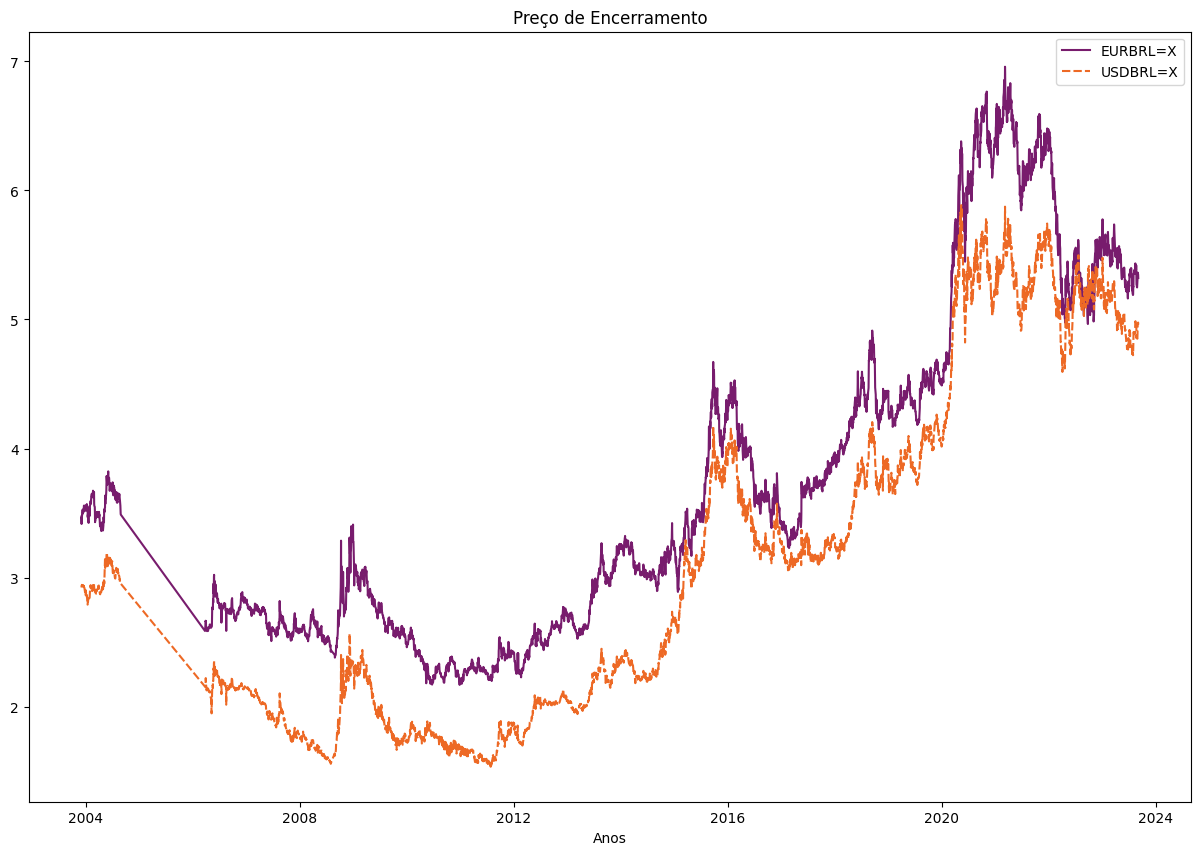

In [ ]:
arr_acoes = [eurobrl, usdbrl]

data = yf.download(arr_acoes)

df = data["Close"]
df.dropna(axis=0, inplace=True)
print("Data Inicial: ", df.index.min())
print("Data Final  : ", df.index.max())
print("Tamanho     : ", len(df))
print('')

fig, ax = plt.subplots(figsize=(15, 10), nrows=1, ncols=1)
sns.lineplot(data=df, palette='inferno', ax=ax,hue_order=arr_acoes)
ax.set_xlabel('Anos')
ax.set_title('Preço de Encerramento')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4700 entries, 2003-12-01 to 2023-09-05
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   EURBRL=X  4700 non-null   float64
 1   USDBRL=X  4700 non-null   float64
dtypes: float64(2)
memory usage: 110.2 KB


In [ ]:
df

,EURBRL=X,USDBRL=X
Date,,
2003-12-01,3.4621,2.9230
2003-12-02,3.4151,2.9310
2003-12-03,3.4799,2.9310
2003-12-04,3.4597,2.9430
2003-12-05,3.4794,2.9340
...,...,...
2023-08-30,5.2805,4.8513
2023-08-31,5.3130,4.8884
2023-09-01,5.3637,4.9538


In [ ]:
df.describe()

,EURBRL=X,USDBRL=X
count,4700.000000,4700.000000
mean,3.705296,3.099767
std,1.266976,1.282237
min,2.167800,1.533700
25%,2.632375,2.008625
50%,3.332650,2.907000
75%,4.424825,3.933275
max,6.959100,5.886400


Seleção e visualização do dataset de Treino e Teste.

---



Data Inicial Treino:  2003-12-01 00:00:00
Data Final   Treino:  2023-08-08 00:00:00
Tamanho      Treino:  4680

Data Inicial Teste:  2023-08-09 00:00:00
Data Final   Teste:  2023-09-05 00:00:00
Tamanho      Teste:  20


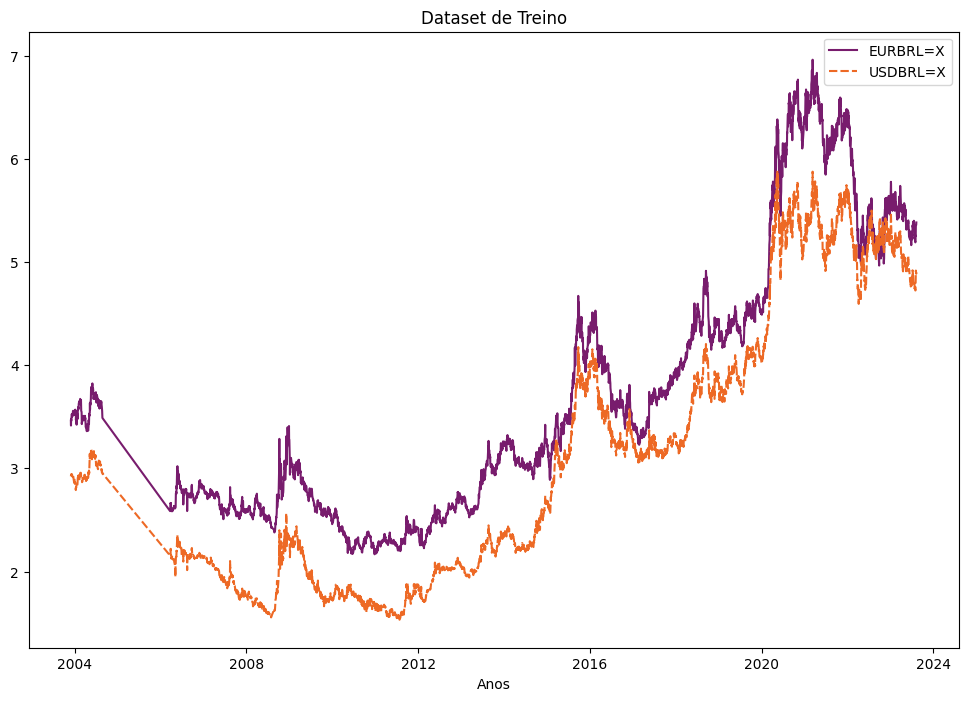

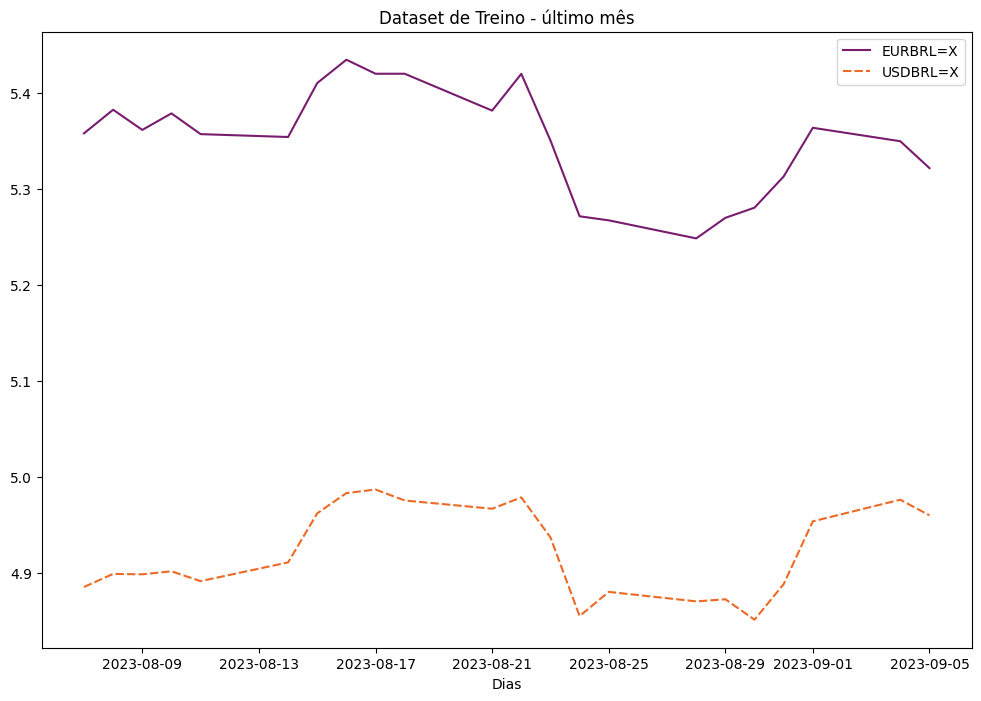

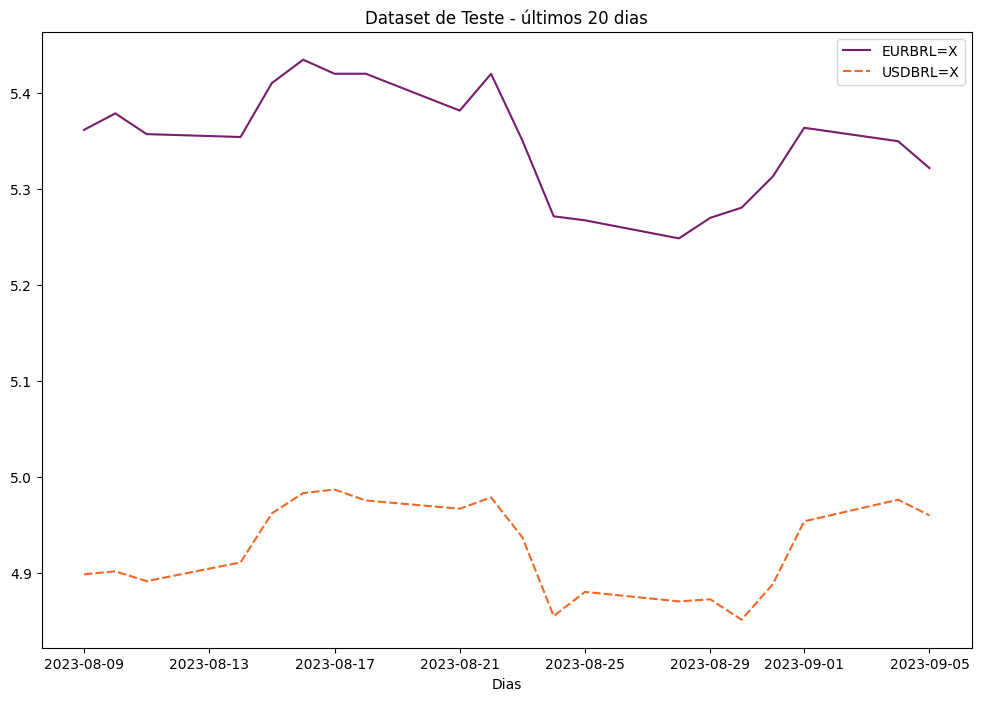

In [ ]:
today = datetime.today()

# prev últimos dias úteis
dias_teste = 20

data_corte_treino = today - timedelta(days=1)
while True:
  data_treino = df.loc[(df.index <= data_corte_treino)]
  data_teste = df.loc[(df.index > data_corte_treino)]
  if len(data_teste) == dias_teste:
    break
  data_corte_treino = data_corte_treino - timedelta(days=1)


print("Data Inicial Treino: ", data_treino.index.min())
print("Data Final   Treino: ", data_treino.index.max())
print("Tamanho      Treino: ", len(data_treino))
print('')

print("Data Inicial Teste: ", data_teste.index.min())
print("Data Final   Teste: ", data_teste.index.max())
print("Tamanho      Teste: ", len(data_teste))

fig, ax = plt.subplots(figsize=(12, 8), nrows=1, ncols=1)
sns.lineplot(data=data_treino, palette="inferno", ax=ax, hue_order=arr_acoes)
ax.set_xlabel('Anos')
ax.set_title('Dataset de Treino')
# ax.set_ylim([0, 80])
plt.show()
print('')


# variáveis não usadas para treino, apenas visualização
tmp_data_corte_treino_30dias = today - timedelta(days=30)
tmp_data_treino_30dias = df.loc[(df.index >= tmp_data_corte_treino_30dias)]
fig, ax = plt.subplots(figsize=(12, 8), nrows=1, ncols=1)
sns.lineplot(data=tmp_data_treino_30dias, palette="inferno", ax=ax, hue_order=arr_acoes)
ax.set_xlabel('Dias')
ax.set_title('Dataset de Treino - último mês')
# ax.set_ylim([0, 80])
plt.show()
print('')

fig, ax = plt.subplots(figsize=(12, 8), nrows=1, ncols=1)
sns.lineplot(data=data_teste, palette="inferno", ax=ax, hue_order=arr_acoes)
ax.set_xlabel('Dias')
ax.set_title(f'Dataset de Teste - últimos {dias_teste} dias')
plt.show()

## Pré Processamento

Função utilizada na transformação da base de dados em 3 dimensões, contendo:

1.   Uma sequência ou mais de exemplos (Batch Size);
2.   Um ponto ou mais de observações em série temporal (Time Steps);
3.   Numero de váriaveis contidas em cada Time Step (Features).

---



In [ ]:
def preprocess(dataset, stock, TimeSteps, TesteLen):

    # StandardScaler
    n = len(dataset[[stock]])
    scaler = StandardScaler()
    scaler = scaler.fit(dataset[[stock]])

    df_scal = scaler.transform(dataset[[stock]])
    df_scal = df_scal.reshape(n, 1)

    X = df_scal
    X_samples = list()
    y_samples = list()

    NumerOfRows = len(X)
    for i in range(int(TimeSteps) , NumerOfRows , 1):
        x_sample = X[i-TimeSteps:i]
        y_sample = X[i]
        X_samples.append(x_sample)
        y_samples.append(y_sample)

    X_data=np.array(X_samples)
    X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)

    y_data=np.array(y_samples)
    y_data=y_data.reshape(y_data.shape[0], 1)

    # Separando dataset entre treino e teste
    if TesteLen > 0:
      X_train=X_data[:-TesteLen]
      X_test=X_data[-TesteLen:]
      y_train=y_data[:-TesteLen]
      y_test=y_data[-TesteLen:]
    else:
      X_train=X_data
      X_test=[]
      y_train=y_data
      y_test=[]
    return scaler, X_train, X_test, y_train, y_test


def preprocess_CNN1D(dataset, stock, TesteLen):
    # StandardScaler
    n = len(dataset[[stock]])
    scaler = StandardScaler()
    scaler = scaler.fit(dataset[[stock]])

    df_scal = scaler.transform(dataset[[stock]])
    df_scal = df_scal.reshape(n, 1)

    X = np.array(df_scal)
    # Separando dataset entre treino e teste
    if TesteLen > 0:
      X_train = X[:-TesteLen]
      X_test = X[-TesteLen:]
    else:
      X_train = X_train
      X_test = []

    y_train, y_test = X_train, X_test
    X_train = X_train.reshape(X_train.shape[0], 1, 1)
    X_test = X_test.reshape(X_test.shape[0], 1, 1)

    return scaler, X_train, X_test, y_train, y_test




Exemplo de transformação do dataset, utilizando 10 observações por batch, separando os ultimos len(data_teste) registros para avaliação dos melhores modelos.



In [ ]:
timesteps = 10
print("LSTM data\n\n")
scaler, X_train, X_test, y_train, y_test = preprocess(df, eurobrl, timesteps, len(data_teste))
for inp, out in zip(X_train[0:3], y_train[0:3]):
  print(inp,'--', out)

print("CNN1D data\n\n")
scaler, X_train, X_test, y_train, y_test = preprocess_CNN1D(df, eurobrl, len(data_teste))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
for inp, out in zip(X_train[0:3], y_train[0:3]):
  print(inp,'--', out)

LSTM data


[[-0.19197007]
 [-0.22907017]
 [-0.17791949]
 [-0.19386448]
 [-0.17831414]
 [-0.15613297]
 [-0.14145079]
 [-0.1505284 ]
 [-0.16481592]
 [-0.14231896]] -- [-0.15700114]
[[-0.22907017]
 [-0.17791949]
 [-0.19386448]
 [-0.17831414]
 [-0.15613297]
 [-0.14145079]
 [-0.1505284 ]
 [-0.16481592]
 [-0.14231896]
 [-0.15700114]] -- [-0.14397662]
[[-0.17791949]
 [-0.19386448]
 [-0.17831414]
 [-0.15613297]
 [-0.14145079]
 [-0.1505284 ]
 [-0.16481592]
 [-0.14231896]
 [-0.15700114]
 [-0.14397662]] -- [-0.12511095]
CNN1D data


(4680, 1, 1) (20, 1, 1) (4680, 1) (20, 1)
[[-0.19197007]] -- [-0.19197007]
[[-0.22907017]] -- [-0.22907017]
[[-0.17791949]] -- [-0.17791949]


## Construção dos modelos RNN

Para desenvolvimento do projeto foram testadas dois modelos de RNN, ambas submetidas ao mesmo dataset e a variação em paramêtros.

Modelo v1:
- 1 camada LSTM com ativação relu
- 1 camada Densa
- 1 camada de ativação linear

Modelo v2:
- 1 camada LSTM com ativação relu
- 1 camada Dropout 10%
- 1 camada LSTM com ativação relu e 1/4 do número de neurônios como input
- 1 camada Dropout 10%
- 1 camada Densa
- 1 camada de ativação linear

In [ ]:
def train_model(mod, optimizer, X, y, batch_size, patience, epochs):

  callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=patience, mode='min',
                                              restore_best_weights=True)

  # only Adam implemented
  if optimizer == "Adam":
    adam = tf.keras.optimizers.Adam()
    mod.compile(loss=tf.losses.MeanSquaredError(),optimizer=adam, metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

  display.display(mod.summary())
  hist = mod.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[callback], verbose=0,
                  shuffle=False)

  loss_metric_train = mod.evaluate(X, y, verbose=0, batch_size=batch_size, use_multiprocessing=True)
  display.display( 'TRAINING set. Loss = {} , MAE = {}'.format(loss_metric_train[0], loss_metric_train[1]))

  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(hist.history['loss'], label="Loss Treino")
  plt.plot(hist.history['val_loss'], label="Loss Validação")
  plt.plot(hist.history['mean_absolute_error'], label='MAE Validação')
  plt.ylim([0.0, 0.2])
  plt.xlim([0.0, epochs])
  plt.legend()
  plt.show()

  return mod, hist


def model_type(mod_type, unit, optimizer, timesteps, X, y, epochs=60, batch_size=32, patience=10):
  func = globals()[mod_type]
  return func(unit, optimizer, timesteps, X, y, epochs, batch_size, patience)


def LSTM_v1(unit, optimizer, timesteps, X, y, epochs, batch_size, patience):

    mod = Sequential()
    mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, 1), return_sequences=False))
    mod.add(Dense(1, activation='linear'))

    mod, hist = train_model(mod, optimizer, X, y, batch_size, patience, epochs)

    return mod, hist


def LSTM_v2(unit, optimizer, timesteps, X, y, epochs, batch_size, patience, l2_reg=0.001):

    mod = Sequential()
    mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, 1), kernel_regularizer=l2(l2_reg),
                 return_sequences=False))
    mod.add(Dense(1, activation='linear'))

    mod, hist = train_model(mod, optimizer, X, y, batch_size, patience, epochs)

    return mod, hist


def LSTM_v3(unit, optimizer, timesteps, X, y, epochs, batch_size, patience, dropout_rate=0.3, l2_reg=0.001):

    mod = Sequential()
    mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, 1), kernel_regularizer=l2(l2_reg),
                 return_sequences=False))
    mod.add(Dropout(dropout_rate))
    mod.add(Dense(1, activation='linear'))

    mod, hist = train_model(mod, optimizer, X, y, batch_size, patience, epochs)

    return mod, hist


def LSTM_v4(unit, optimizer, timesteps, X, y, epochs, batch_size, patience, dropout_rate=0.3):

    mod = Sequential()
    mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, 1), return_sequences=True))
    mod.add(Dropout(0.1))
    mod.add(LSTM(int(unit/4), activation='relu', return_sequences=False ))
    mod.add(Dropout(0.1))
    mod.add(Dense(1, activation='linear'))

    mod, hist = train_model(mod, optimizer, X, y, batch_size, patience, epochs)

    return mod, hist


def CNN_v1(unit, optimizer, timesteps, X, y, epochs, batch_size, patience):

  mod = Sequential()
  mod.add(Conv1D(filters=unit, kernel_size=2, activation='relu', input_shape=(1,1)))
  # mod.add(BatchNormalization())
  mod.add(Activation("relu"))
  # mod.add(MaxPooling1D(pool_size=3))
  mod.add(Flatten())
  mod.add(Dense(1, activation='linear'))

  mod, hist = train_model(mod, optimizer, X, y, batch_size, patience, epochs)
  return mod, hist

## Treinamento e Hiperparâmetrização

Parâmetros variados

1. Modelo: v1 ou v2
2. Numéro de Neurônios:  [64, 128]
3. Batch size: [16, 32, 64]


Treinando EURBRL=X com LSTM_v1 , units=64, batch=16
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.014097270555794239 , MAE = 0.09408560395240784'

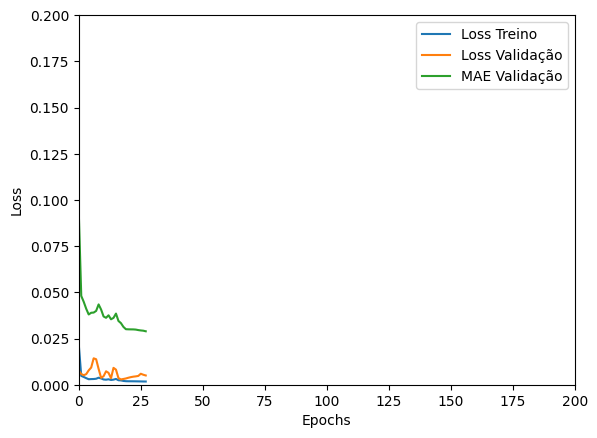

Tempo de treino: 1.425860548019409 minutos
1/1 [==============================] - 0s 319ms/step
Treinando EURBRL=X com LSTM_v1 , units=64, batch=32
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.011277616024017334 , MAE = 0.08317568153142929'

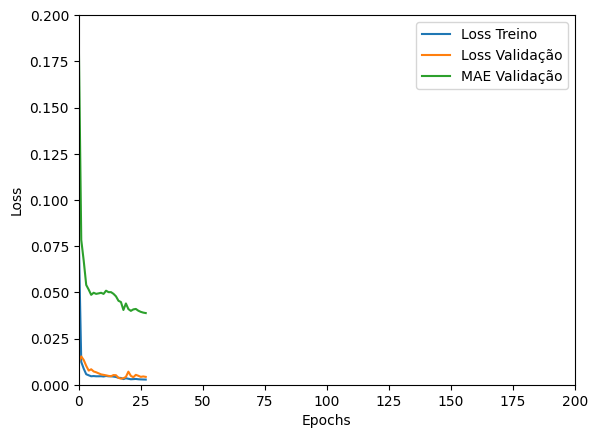

Tempo de treino: 0.7333498438199361 minutos
1/1 [==============================] - 0s 214ms/step
Treinando EURBRL=X com LSTM_v1 , units=64, batch=64
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.009301888756453991 , MAE = 0.07161013782024384'

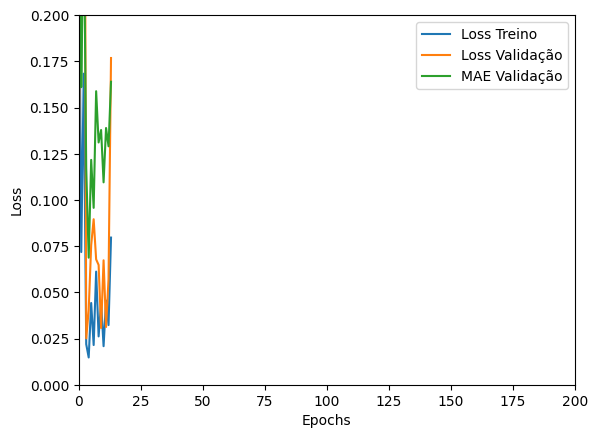

Tempo de treino: 0.22359442710876465 minutos
1/1 [==============================] - 0s 207ms/step
Treinando EURBRL=X com LSTM_v1 , units=128, batch=16
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               66560     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.02814299613237381 , MAE = 0.13484224677085876'

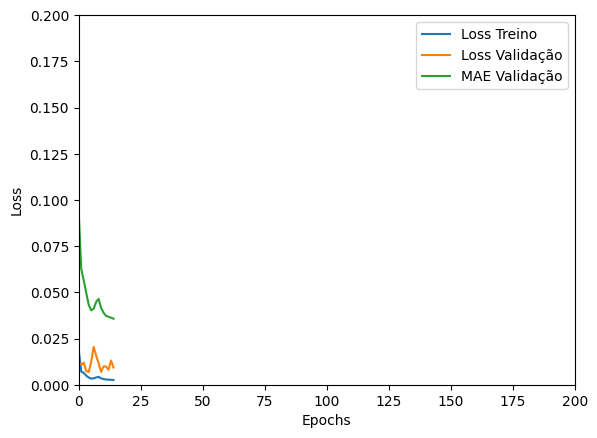

Tempo de treino: 1.4225218772888184 minutos
1/1 [==============================] - 0s 189ms/step
Treinando EURBRL=X com LSTM_v1 , units=128, batch=32
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               66560     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.016230672597885132 , MAE = 0.10333364456892014'

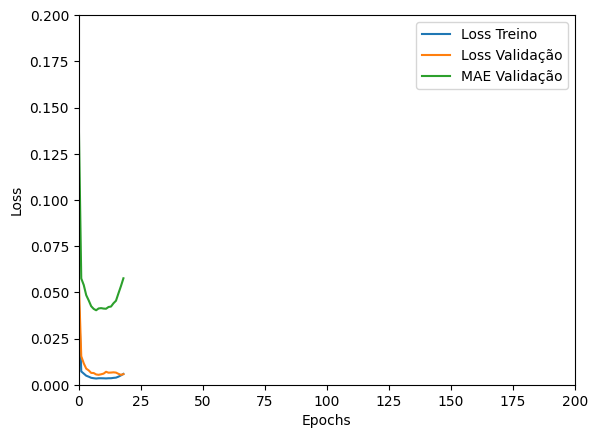

Tempo de treino: 1.4277331431706746 minutos


1/1 [==============================] - 0s 184ms/step
Treinando EURBRL=X com LSTM_v1 , units=128, batch=64
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               66560     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.022001810371875763 , MAE = 0.1278064250946045'

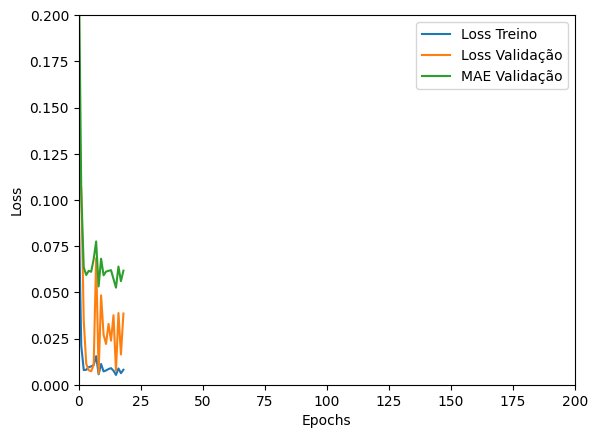

Tempo de treino: 0.5507174015045166 minutos


1/1 [==============================] - 0s 298ms/step
Treinando EURBRL=X com LSTM_v2 , units=64, batch=16
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.027259880676865578 , MAE = 0.13295678794384003'

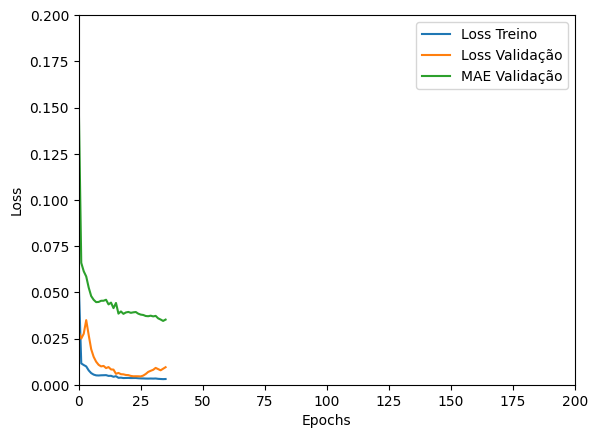

Tempo de treino: 1.1806507984797159 minutos
1/1 [==============================] - 0s 185ms/step
Treinando EURBRL=X com LSTM_v2 , units=64, batch=32
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                16896     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.02280033379793167 , MAE = 0.11295198649168015'

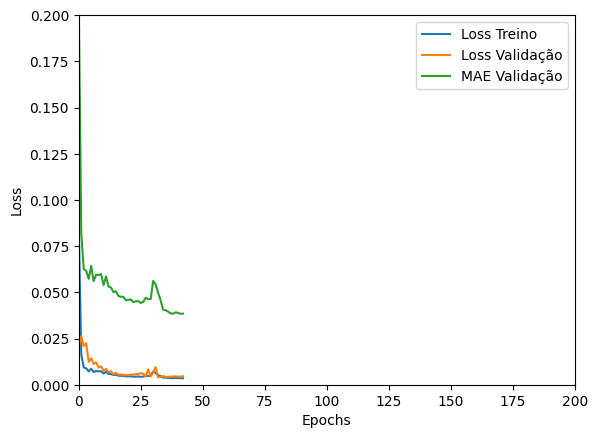

Tempo de treino: 0.8145556886990865 minutos
1/1 [==============================] - 0s 228ms/step
Treinando EURBRL=X com LSTM_v2 , units=64, batch=64
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.0038118751253932714 , MAE = 0.03736857324838638'

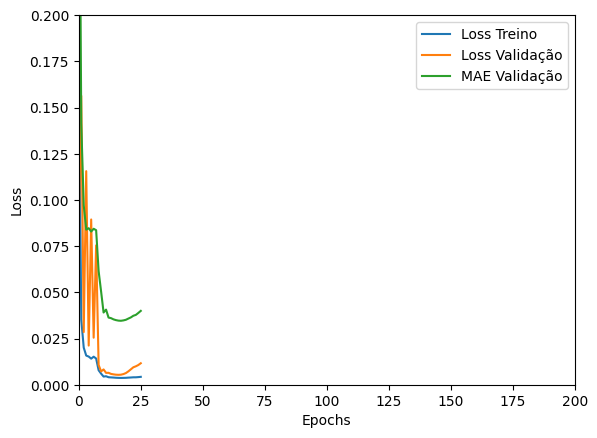

Tempo de treino: 0.3874109665552775 minutos
1/1 [==============================] - 0s 220ms/step
Treinando EURBRL=X com LSTM_v2 , units=128, batch=16
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 128)               66560     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.05637577548623085 , MAE = 0.19123172760009766'

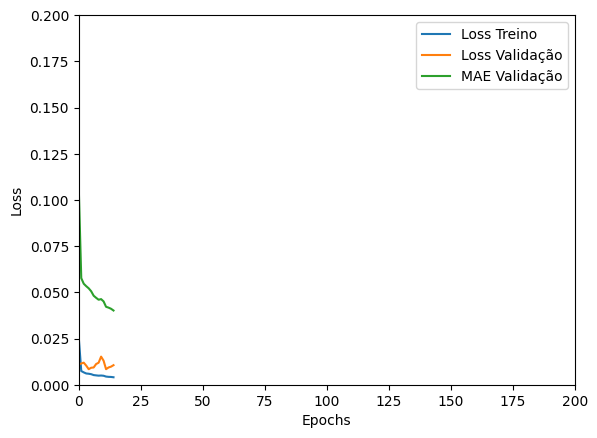

Tempo de treino: 1.430831782023112 minutos
1/1 [==============================] - 0s 212ms/step
Treinando EURBRL=X com LSTM_v2 , units=128, batch=32
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128)               66560     
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.019661573693156242 , MAE = 0.10557214170694351'

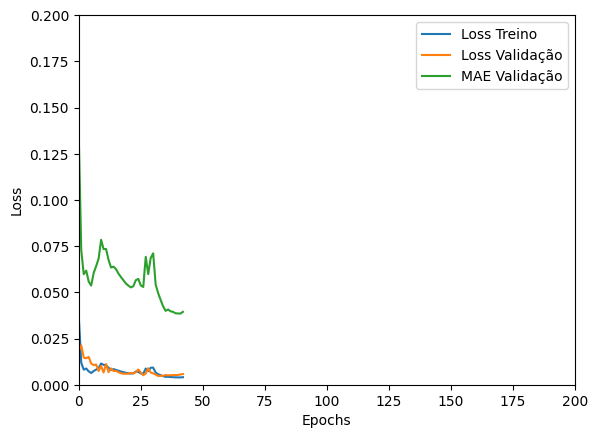

Tempo de treino: 2.4238999048868815 minutos
1/1 [==============================] - 0s 278ms/step
Treinando EURBRL=X com LSTM_v2 , units=128, batch=64
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 128)               66560     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.009560685604810715 , MAE = 0.07950751483440399'

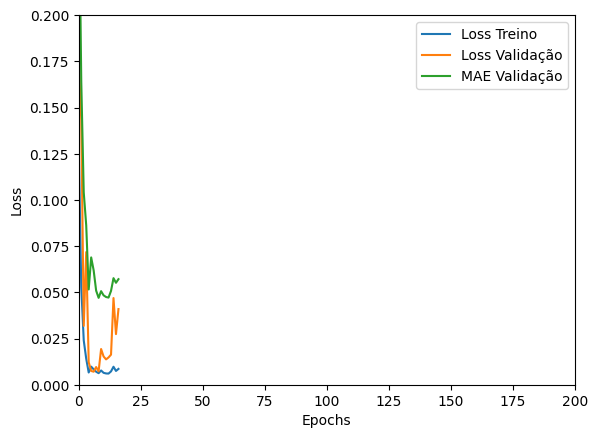

Tempo de treino: 0.7351652224858601 minutos
1/1 [==============================] - 0s 205ms/step
Treinando EURBRL=X com LSTM_v3 , units=64, batch=16
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.05479275807738304 , MAE = 0.18670080602169037'

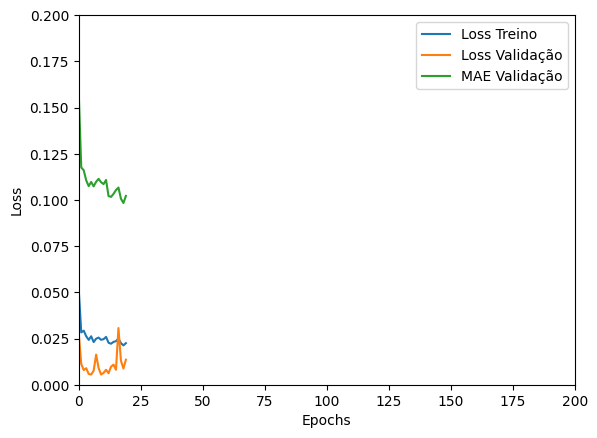

Tempo de treino: 0.7429343144098918 minutos
1/1 [==============================] - 0s 267ms/step
Treinando EURBRL=X com LSTM_v3 , units=64, batch=32
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.017230981960892677 , MAE = 0.0982244685292244'

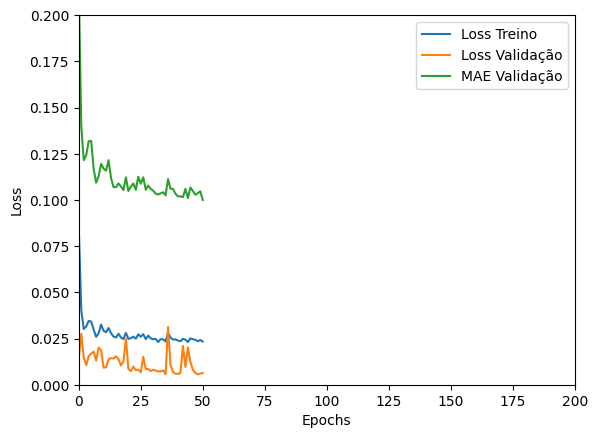

Tempo de treino: 1.4113765319188436 minutos
1/1 [==============================] - 0s 197ms/step
Treinando EURBRL=X com LSTM_v3 , units=64, batch=64
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.013598013669252396 , MAE = 0.09043925255537033'

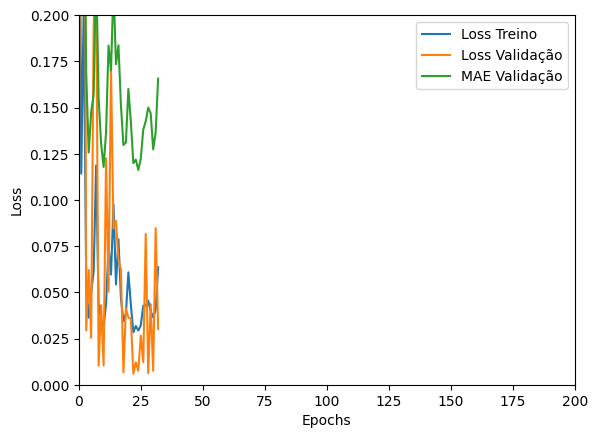

Tempo de treino: 0.7378093560536703 minutos
1/1 [==============================] - 0s 196ms/step
Treinando EURBRL=X com LSTM_v3 , units=128, batch=16
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.036279574036598206 , MAE = 0.1428288221359253'

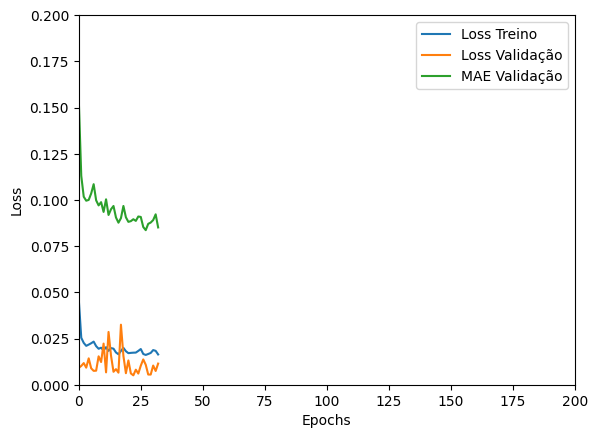

Tempo de treino: 2.4236374815305073 minutos
1/1 [==============================] - 0s 194ms/step
Treinando EURBRL=X com LSTM_v3 , units=128, batch=32
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.05191105604171753 , MAE = 0.1789090782403946'

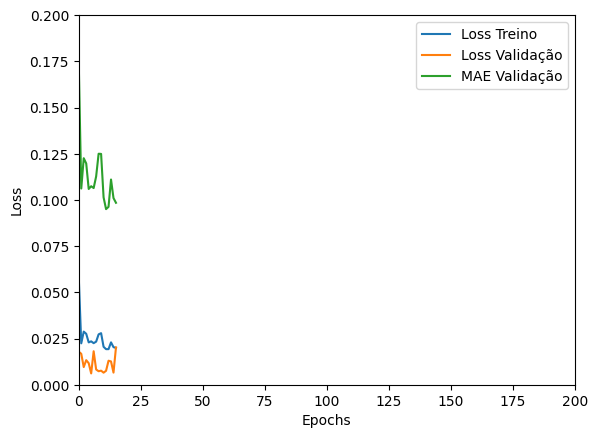

Tempo de treino: 0.7425879836082458 minutos
1/1 [==============================] - 0s 190ms/step
Treinando EURBRL=X com LSTM_v3 , units=128, batch=64
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.04200237989425659 , MAE = 0.16934865713119507'

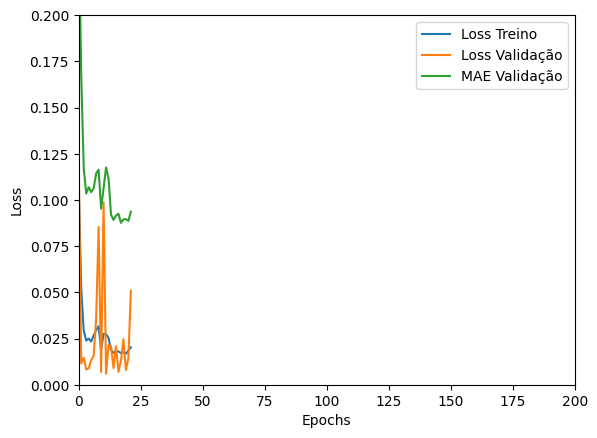

Tempo de treino: 0.7316195209821065 minutos
1/1 [==============================] - 0s 189ms/step
Treinando EURBRL=X com LSTM_v4 , units=64, batch=16
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 64)            16896     
                                                                 
 dropout_6 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_19 (LSTM)              (None, 16)                5184      
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 17        
                                                                 
Total params: 22,097
Trainable param

None

'TRAINING set. Loss = 0.07414152473211288 , MAE = 0.2165430784225464'

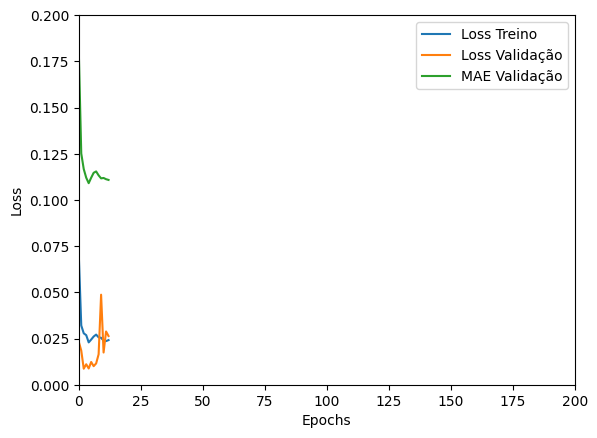

Tempo de treino: 0.7716469287872314 minutos
1/1 [==============================] - 0s 477ms/step
Treinando EURBRL=X com LSTM_v4 , units=64, batch=32
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 10, 64)            16896     
                                                                 
 dropout_8 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_21 (LSTM)              (None, 16)                5184      
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 22,097
Trainable param

None

'TRAINING set. Loss = 0.07338821142911911 , MAE = 0.2115696668624878'

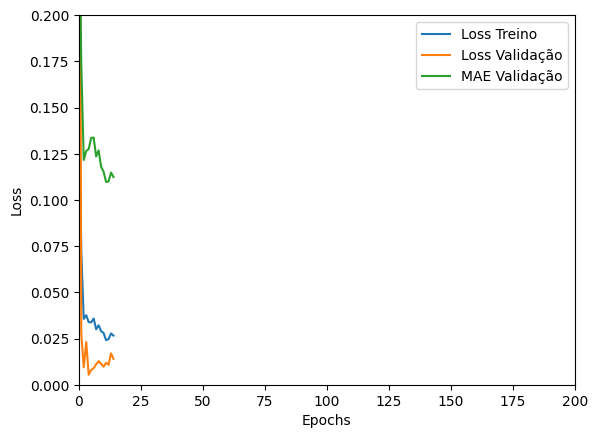

Tempo de treino: 0.5374887228012085 minutos
1/1 [==============================] - 0s 314ms/step
Treinando EURBRL=X com LSTM_v4 , units=64, batch=64
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 10, 64)            16896     
                                                                 
 dropout_10 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_23 (LSTM)              (None, 16)                5184      
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 22,097
Trainable param

None

'TRAINING set. Loss = 0.05544734373688698 , MAE = 0.20019656419754028'

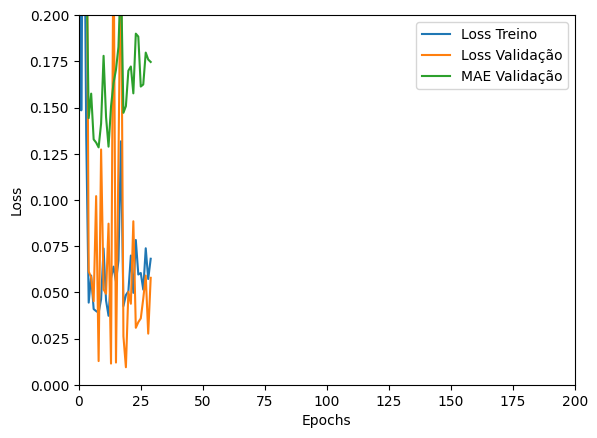

Tempo de treino: 0.754956042766571 minutos
1/1 [==============================] - 0s 485ms/step
Treinando EURBRL=X com LSTM_v4 , units=128, batch=16
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 10, 128)           66560     
                                                                 
 dropout_12 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_25 (LSTM)              (None, 32)                20608     
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 87,201
Trainable param

None

'TRAINING set. Loss = 0.01351025141775608 , MAE = 0.08787307143211365'

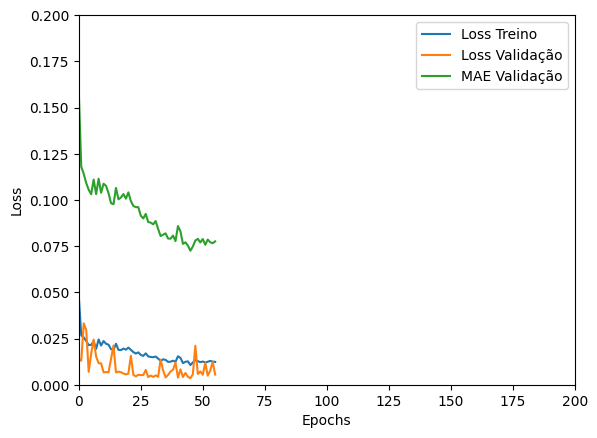

Tempo de treino: 4.471878735224406 minutos
1/1 [==============================] - 0s 498ms/step
Treinando EURBRL=X com LSTM_v4 , units=128, batch=32
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 10, 128)           66560     
                                                                 
 dropout_14 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_27 (LSTM)              (None, 32)                20608     
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 33        
                                                                 
Total params: 87,201
Trainable param

None

'TRAINING set. Loss = 0.0283509474247694 , MAE = 0.1271679550409317'

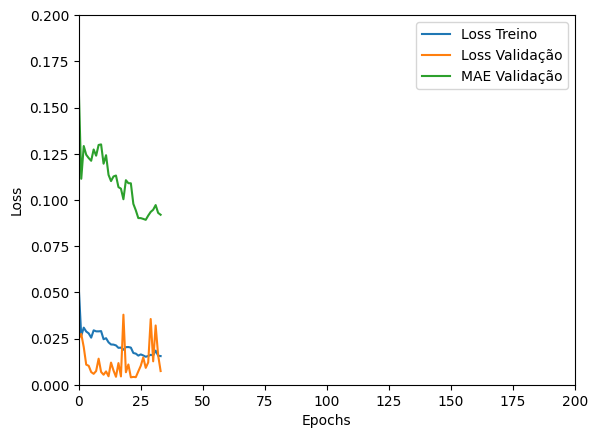

Tempo de treino: 2.005583202838898 minutos
1/1 [==============================] - 0s 317ms/step
Treinando EURBRL=X com LSTM_v4 , units=128, batch=64
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 10, 128)           66560     
                                                                 
 dropout_16 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_29 (LSTM)              (None, 32)                20608     
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 87,201
Trainable param

None

'TRAINING set. Loss = 0.03296251967549324 , MAE = 0.1421148180961609'

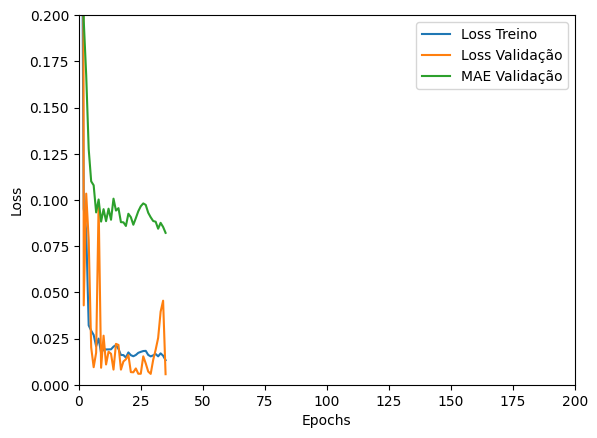

Tempo de treino: 1.4470632950464883 minutos
1/1 [==============================] - 0s 320ms/step
Treinando USDBRL=X com LSTM_v1 , units=64, batch=16
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 64)                16896     
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.01299345400184393 , MAE = 0.09266089648008347'

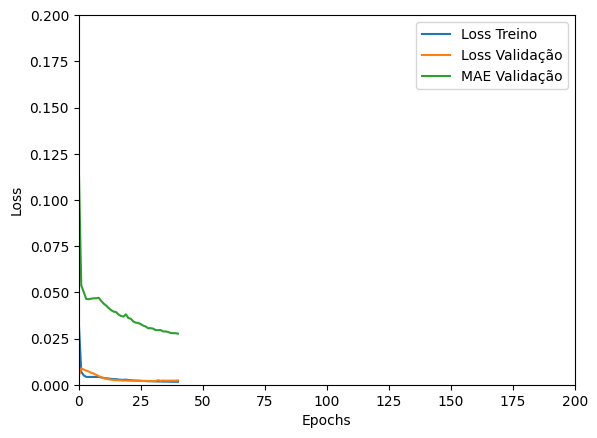

Tempo de treino: 1.3484727104504903 minutos
1/1 [==============================] - 0s 202ms/step
Treinando USDBRL=X com LSTM_v1 , units=64, batch=32
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 64)                16896     
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.0022828825749456882 , MAE = 0.036518193781375885'

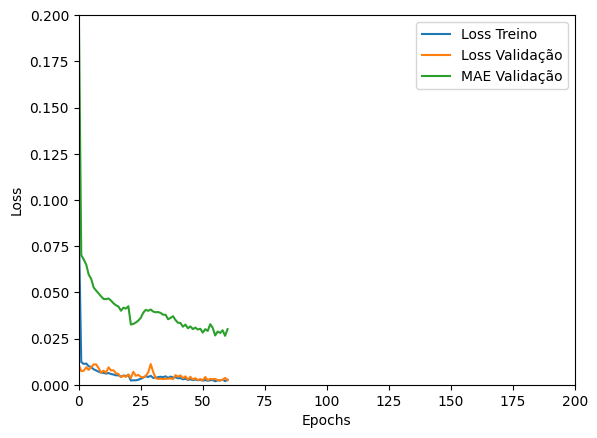

Tempo de treino: 1.113947908083598 minutos
1/1 [==============================] - 0s 196ms/step
Treinando USDBRL=X com LSTM_v1 , units=64, batch=64
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 64)                16896     
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.005572470370680094 , MAE = 0.062242090702056885'

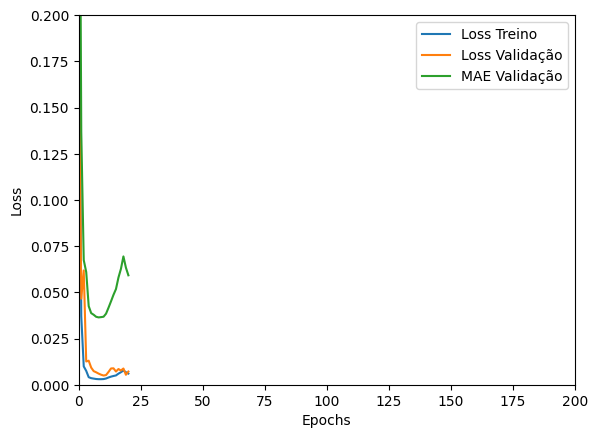

Tempo de treino: 0.29624951283137 minutos
1/1 [==============================] - 0s 194ms/step
Treinando USDBRL=X com LSTM_v1 , units=128, batch=16
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 128)               66560     
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.015089231543242931 , MAE = 0.09835813194513321'

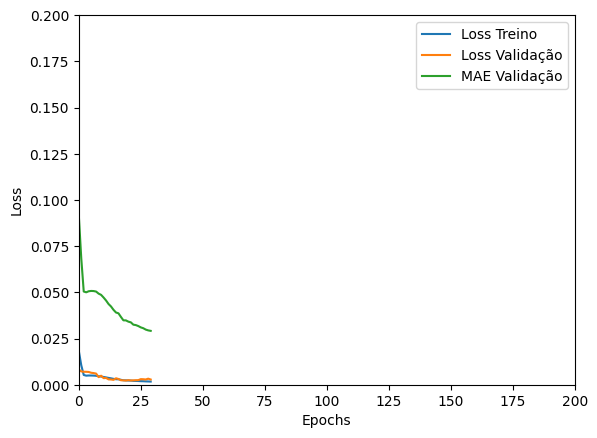

Tempo de treino: 2.4170351664225262 minutos
1/1 [==============================] - 0s 195ms/step
Treinando USDBRL=X com LSTM_v1 , units=128, batch=32
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 128)               66560     
                                                                 
 dense_28 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.005762207787483931 , MAE = 0.06329583376646042'

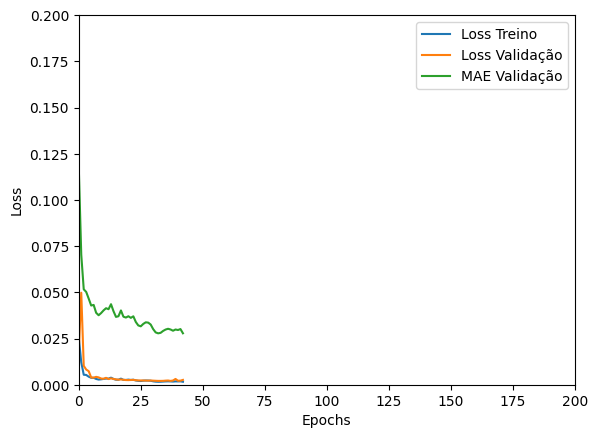

Tempo de treino: 1.7970869302749635 minutos
1/1 [==============================] - 0s 184ms/step
Treinando USDBRL=X com LSTM_v1 , units=128, batch=64
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 128)               66560     
                                                                 
 dense_29 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.019575519487261772 , MAE = 0.11146057397127151'

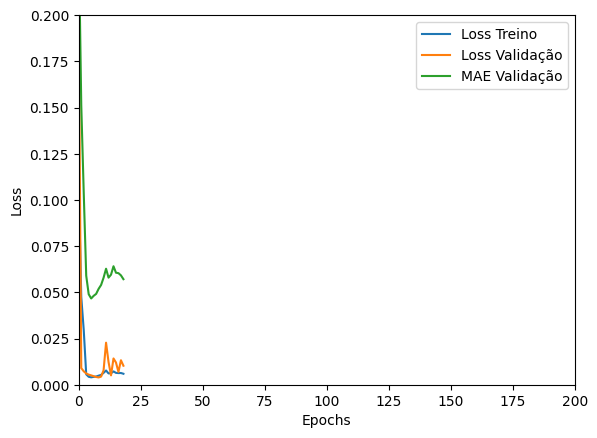

Tempo de treino: 0.5386862635612488 minutos
1/1 [==============================] - 1s 1s/step
Treinando USDBRL=X com LSTM_v2 , units=64, batch=16
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 64)                16896     
                                                                 
 dense_30 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.03230280429124832 , MAE = 0.1398617923259735'

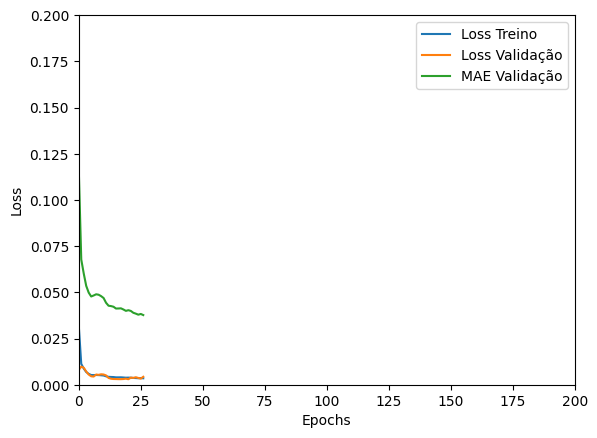

Tempo de treino: 1.4333722790082295 minutos
1/1 [==============================] - 0s 210ms/step
Treinando USDBRL=X com LSTM_v2 , units=64, batch=32
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 64)                16896     
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.020757576450705528 , MAE = 0.10660729557275772'

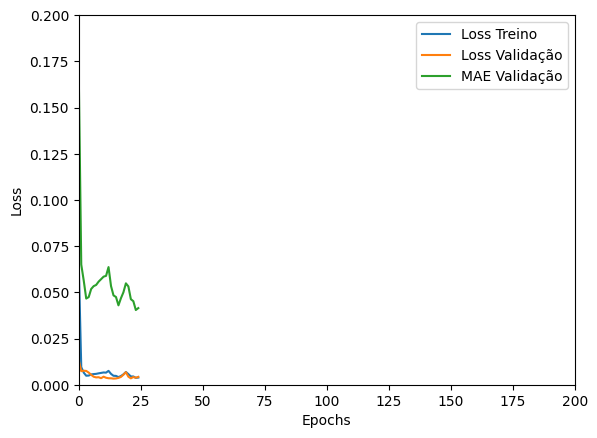

Tempo de treino: 0.7303091526031494 minutos
1/1 [==============================] - 0s 192ms/step
Treinando USDBRL=X com LSTM_v2 , units=64, batch=64
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 64)                16896     
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.00798637792468071 , MAE = 0.06922963261604309'

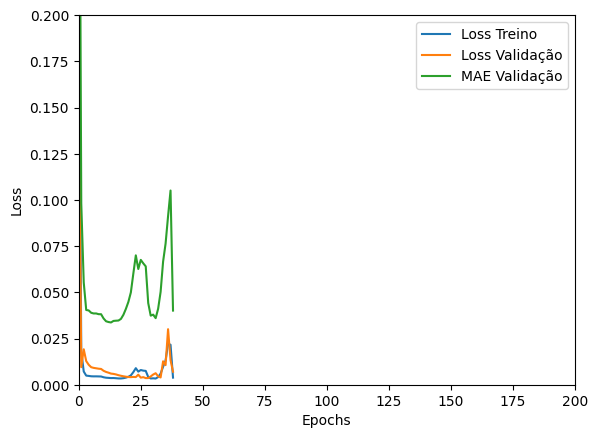

Tempo de treino: 0.7245489199956258 minutos
1/1 [==============================] - 0s 199ms/step
Treinando USDBRL=X com LSTM_v2 , units=128, batch=16
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 128)               66560     
                                                                 
 dense_33 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.030733579769730568 , MAE = 0.13712309300899506'

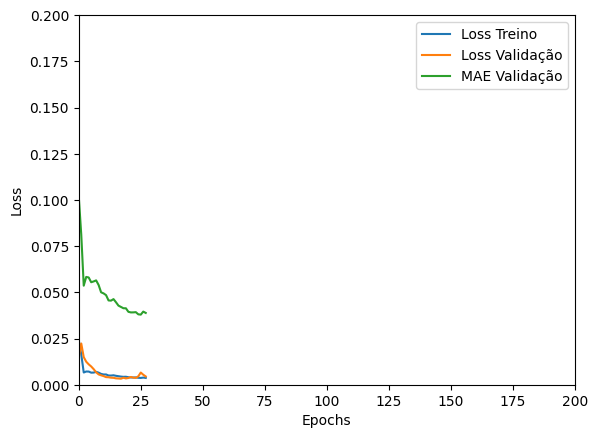

Tempo de treino: 1.439450498421987 minutos
1/1 [==============================] - 0s 202ms/step
Treinando USDBRL=X com LSTM_v2 , units=128, batch=32
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 128)               66560     
                                                                 
 dense_34 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.03864603489637375 , MAE = 0.152345672249794'

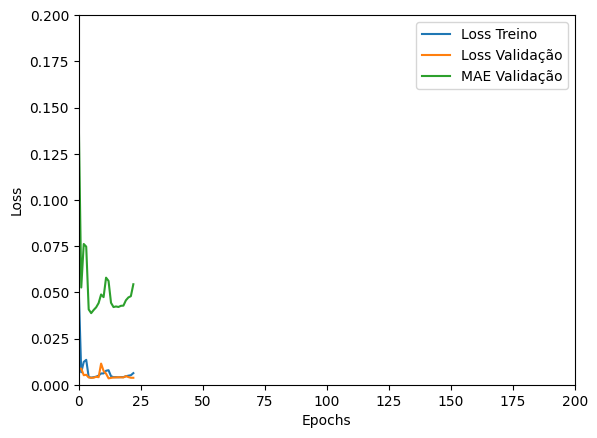

Tempo de treino: 1.424431582291921 minutos
1/1 [==============================] - 0s 193ms/step
Treinando USDBRL=X com LSTM_v2 , units=128, batch=64
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 128)               66560     
                                                                 
 dense_35 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.012226617895066738 , MAE = 0.09071879833936691'

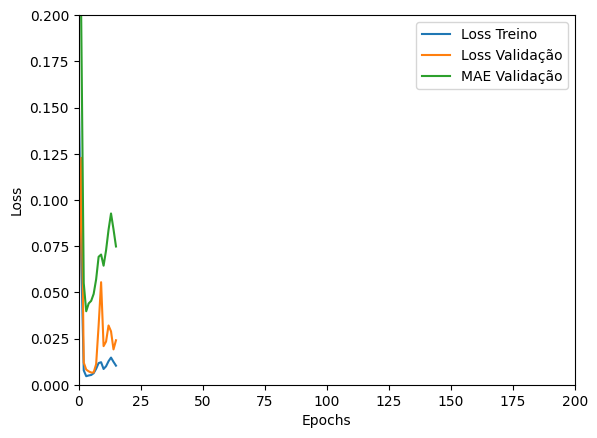

Tempo de treino: 0.7291275223096212 minutos
1/1 [==============================] - 0s 225ms/step
Treinando USDBRL=X com LSTM_v3 , units=64, batch=16
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.03617827594280243 , MAE = 0.1489490270614624'

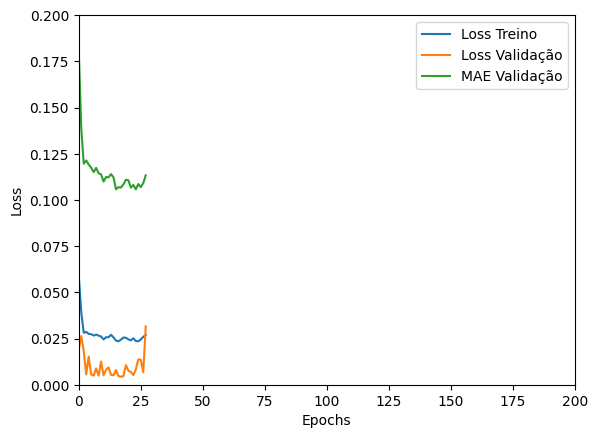

Tempo de treino: 0.9840019663174947 minutos
1/1 [==============================] - 0s 189ms/step
Treinando USDBRL=X com LSTM_v3 , units=64, batch=32
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.03221497684717178 , MAE = 0.14243024587631226'

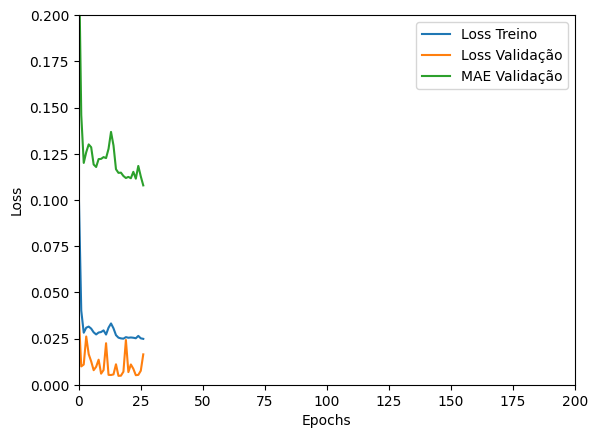

Tempo de treino: 0.7335871736208598 minutos
1/1 [==============================] - 0s 279ms/step
Treinando USDBRL=X com LSTM_v3 , units=64, batch=64
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.020025933161377907 , MAE = 0.1127634048461914'

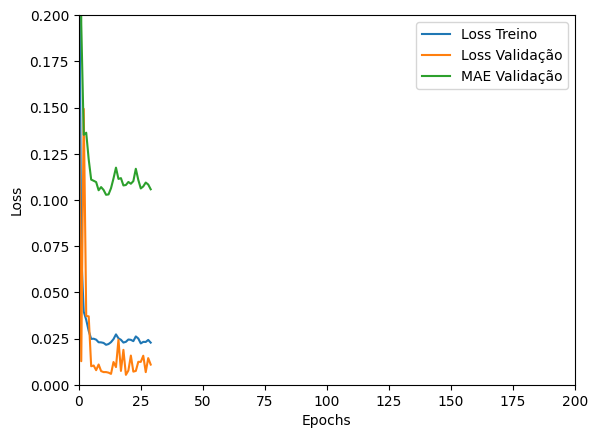

Tempo de treino: 0.39041407108306886 minutos
1/1 [==============================] - 0s 196ms/step
Treinando USDBRL=X com LSTM_v3 , units=128, batch=16
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.020125070586800575 , MAE = 0.10796518623828888'

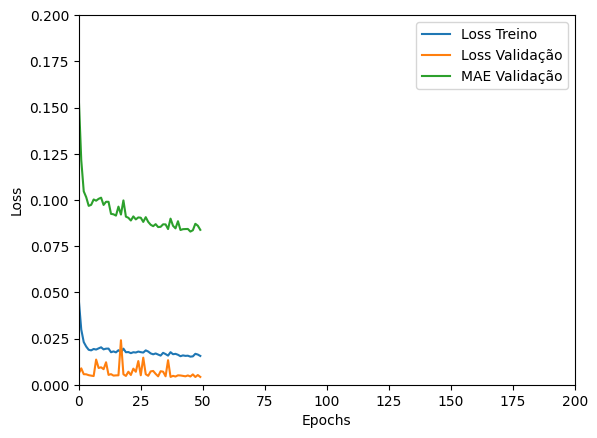

Tempo de treino: 3.433184293905894 minutos
1/1 [==============================] - 0s 201ms/step
Treinando USDBRL=X com LSTM_v3 , units=128, batch=32
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_40 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.027521569281816483 , MAE = 0.1283644437789917'

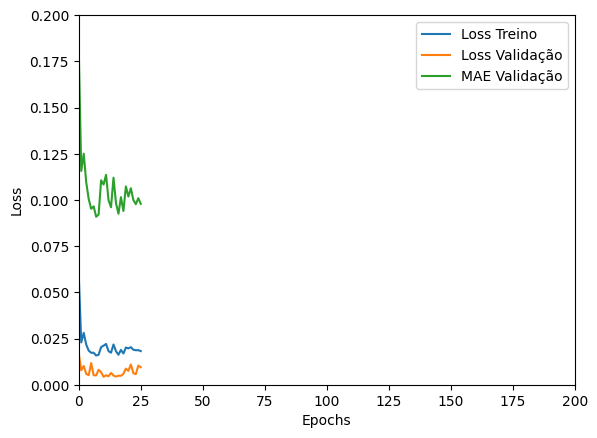

Tempo de treino: 1.446673540274302 minutos
1/1 [==============================] - 0s 196ms/step
Treinando USDBRL=X com LSTM_v3 , units=128, batch=64
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

'TRAINING set. Loss = 0.03394898399710655 , MAE = 0.1525157243013382'

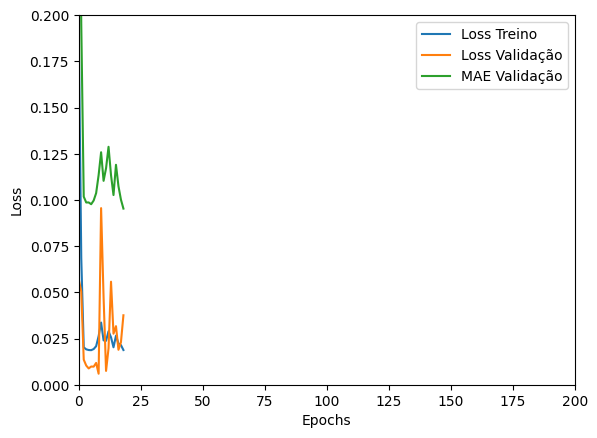

Tempo de treino: 0.5775972445805867 minutos
1/1 [==============================] - 0s 276ms/step
Treinando USDBRL=X com LSTM_v4 , units=64, batch=16
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 10, 64)            16896     
                                                                 
 dropout_24 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_49 (LSTM)              (None, 16)                5184      
                                                                 
 dropout_25 (Dropout)        (None, 16)                0         
                                                                 
 dense_42 (Dense)            (None, 1)                 17        
                                                                 
Total params: 22,097
Trainable param

None

'TRAINING set. Loss = 0.0960201695561409 , MAE = 0.24481527507305145'

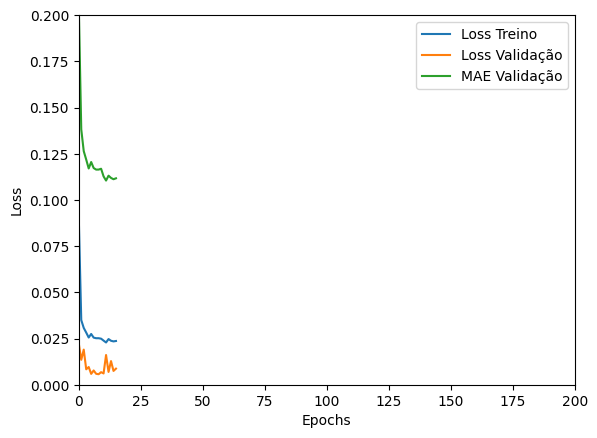

Tempo de treino: 1.4617670973141987 minutos
1/1 [==============================] - 0s 487ms/step
Treinando USDBRL=X com LSTM_v4 , units=64, batch=32
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 10, 64)            16896     
                                                                 
 dropout_26 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_51 (LSTM)              (None, 16)                5184      
                                                                 
 dropout_27 (Dropout)        (None, 16)                0         
                                                                 
 dense_43 (Dense)            (None, 1)                 17        
                                                                 
Total params: 22,097
Trainable param

None

'TRAINING set. Loss = 0.02214748039841652 , MAE = 0.11677306145429611'

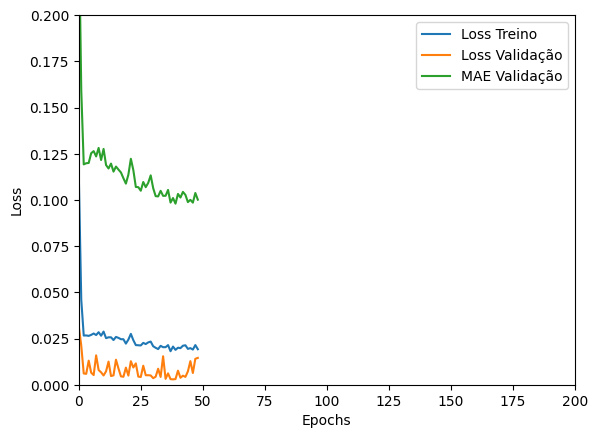

Tempo de treino: 2.4447581926981607 minutos
1/1 [==============================] - 0s 337ms/step
Treinando USDBRL=X com LSTM_v4 , units=64, batch=64
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 10, 64)            16896     
                                                                 
 dropout_28 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_53 (LSTM)              (None, 16)                5184      
                                                                 
 dropout_29 (Dropout)        (None, 16)                0         
                                                                 
 dense_44 (Dense)            (None, 1)                 17        
                                                                 
Total params: 22,097
Trainable param

None

'TRAINING set. Loss = 0.019214550033211708 , MAE = 0.11428101360797882'

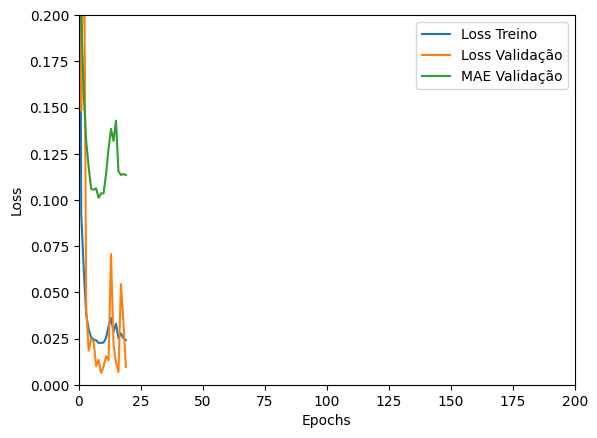

Tempo de treino: 0.45167919794718425 minutos
1/1 [==============================] - 0s 480ms/step
Treinando USDBRL=X com LSTM_v4 , units=128, batch=16
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 10, 128)           66560     
                                                                 
 dropout_30 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_55 (LSTM)              (None, 32)                20608     
                                                                 
 dropout_31 (Dropout)        (None, 32)                0         
                                                                 
 dense_45 (Dense)            (None, 1)                 33        
                                                                 
Total params: 87,201
Trainable par

None

'TRAINING set. Loss = 0.013141273520886898 , MAE = 0.09748955070972443'

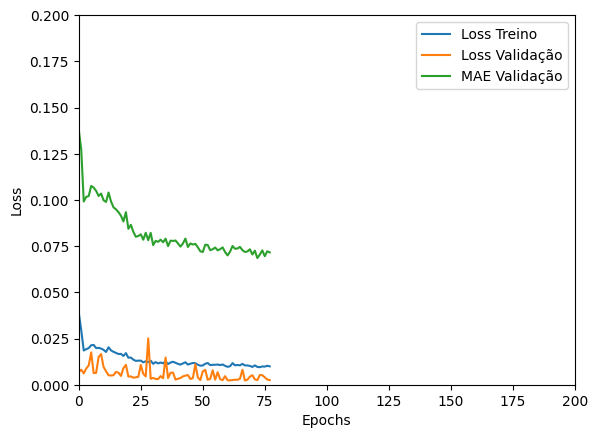

Tempo de treino: 6.459300303459168 minutos
1/1 [==============================] - 0s 339ms/step
Treinando USDBRL=X com LSTM_v4 , units=128, batch=32
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 10, 128)           66560     
                                                                 
 dropout_32 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_57 (LSTM)              (None, 32)                20608     
                                                                 
 dropout_33 (Dropout)        (None, 32)                0         
                                                                 
 dense_46 (Dense)            (None, 1)                 33        
                                                                 
Total params: 87,201
Trainable param

None

'TRAINING set. Loss = 0.0577155239880085 , MAE = 0.1781410425901413'

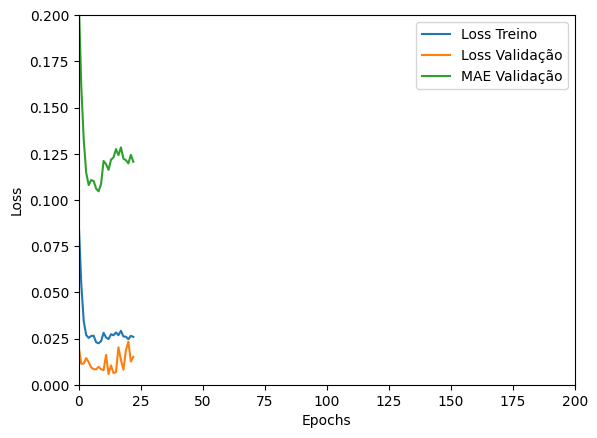

Tempo de treino: 1.45253613392512 minutos
1/1 [==============================] - 0s 345ms/step
Treinando USDBRL=X com LSTM_v4 , units=128, batch=64
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 10, 128)           66560     
                                                                 
 dropout_34 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_59 (LSTM)              (None, 32)                20608     
                                                                 
 dropout_35 (Dropout)        (None, 32)                0         
                                                                 
 dense_47 (Dense)            (None, 1)                 33        
                                                                 
Total params: 87,201
Trainable params

None

'TRAINING set. Loss = 0.06327857822179794 , MAE = 0.1979190558195114'

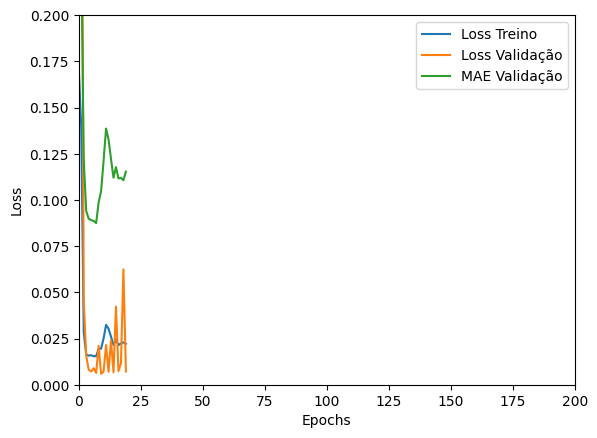

Tempo de treino: 0.8706375519434612 minutos
1/1 [==============================] - 0s 348ms/step


In [ ]:
all_results = pd.DataFrame(columns=["model_type","model","stock","unit","optimizer", "batch_size", "loss","mae"])

arr_acoes_hyperparams = arr_acoes
model_hyperparams = ['LSTM_v1', 'LSTM_v2', 'LSTM_v3', 'LSTM_v4']
unit_hyperparams = [64, 128]
batch_hyperparams = [16, 32, 64]

# arr_acoes= [usdbrl]
# arr_acoes_hyperparams = arr_acoes
# model_hyperparams = ['LSTM_v1']
# unit_hyperparams = [128]
# batch_hyperparams = [64]

TotalFeatures = 1
epochs = 200
i = 1
times_exec = 1

result_all_best = None
# result_all_best = pd.DataFrame(columns=["model_type", "stock","unit","optimizer", "batch_size", "loss","mse"])
# result_all_best = result_all_best.append({'model_type':'model_v1', 'stock':eurobrl, 'unit': 128, 'optimizer': 'Adam', 'batch_size': 64, 'loss': 0.001344, 'mse': 0.031031}, ignore_index=True)
# result_all_best = result_all_best.append({'model_type':'model_v2', 'stock':usdbrl,  'unit': 128, 'optimizer': 'Adam', 'batch_size': 32, 'loss': 0.000670, 'mse': 0.021304}, ignore_index=True)


if result_all_best is not None:

  pass
  # for index, item in result_all_best.iterrows():
  #   scaler, X_train, X_test, y_train, y_test = preprocess(df, item['stock'], timesteps, len(data_teste))
  #   inittime = time()
  #   m, h = model_type(item['model_type'], unit=item['unit'], optimizer=item['optimizer'], timesteps=timesteps, X=X_train, y=y_train, epochs=epochs, batch_size=item['batch_size'])
  #   endtime = time()
  #   print(f'Tempo de treino: {(endtime-inittime)/60} minutos' )
  #   y_pred = m.predict(X_test)
  #   score = m.evaluate(X_test, y_test, batch_size=32, verbose=0)
  #   all_results = all_results.append({'model_type': item['model_type'], 'model':m, 'stock':item['stock'],'unit':item['unit'], \
  #     'optimizer':item['optimizer'], "batch_size":item['batch_size'], "loss":score[0], "mse":score[1]}, ignore_index=True)

else:

  for times in range(times_exec):
    for stock in arr_acoes_hyperparams:
      for model_type_str in model_hyperparams:
        if model_type_str[:4] == 'LSTM':
          scaler, X_train, X_test, y_train, y_test = preprocess(df, stock, timesteps, len(data_teste))
        elif model_type_str[:3] == 'CNN':
          scaler, X_train, X_test, y_train, y_test = preprocess_CNN1D(df, stock, len(data_teste))
        for optimizer in ['Adam']:
          for unit in unit_hyperparams:
            for batch_size in batch_hyperparams:
              inittime = time()
              print(f"Treinando {stock} com {model_type_str} , units={unit}, batch={batch_size}")
              m, h = model_type(model_type_str, unit=unit, optimizer=optimizer, timesteps=timesteps, X=X_train, y=y_train, epochs=epochs, batch_size=batch_size)
              endtime = time()
              print(f'Tempo de treino: {(endtime-inittime)/60} minutos' )
              y_pred = m.predict(X_test)
              score = m.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
              all_results = all_results.append({'model_type': model_type_str, 'model':m, 'stock':stock,'unit':unit, 'optimizer':optimizer,
                                            "loss":score[0], "mae":score[1], "mse":score[2], "batch_size":batch_size}, ignore_index=True)

## Avaliação na base de testes
Desempenho ordenado por moeda e menor mse na base de testes

In [ ]:
all_results.sort_values(by=['stock','mse'])

,model_type,model,stock,unit,optimizer,batch_size,loss,mae,mse
0,LSTM_v1,<keras.engine.sequential.Sequential object at ...,EURBRL=X,64,Adam,16,0.001169,0.026120,0.001169
21,LSTM_v4,<keras.engine.sequential.Sequential object at ...,EURBRL=X,128,Adam,16,0.001361,0.027540,0.001361
1,LSTM_v1,<keras.engine.sequential.Sequential object at ...,EURBRL=X,64,Adam,32,0.001372,0.027871,0.001372
15,LSTM_v3,<keras.engine.sequential.Sequential object at ...,EURBRL=X,128,Adam,16,0.002823,0.030572,0.001533
22,LSTM_v4,<keras.engine.sequential.Sequential object at ...,EURBRL=X,128,Adam,32,0.001609,0.033329,0.001609
7,LSTM_v2,<keras.engine.sequential.Sequential object at ...,EURBRL=X,64,Adam,32,0.002392,0.032544,0.001664
12,LSTM_v3,<keras.engine.sequential.Sequential object at ...,EURBRL=X,64,Adam,16,0.002695,0.036914,0.001971
4,LSTM_v1,<keras.engine.sequential.Sequential object at ...,EURBRL=X,128,Adam,32,0.002008,0.032830,0.002008
8,LSTM_v2,<keras.engine.sequential.Sequential object at ...,EURBRL=X,64,Adam,64,0.002941,0.039849,0.002058
6,LSTM_v2,<keras.engine.sequential.Sequential object at ...,EURBRL=X,64,Adam,16,0.002904,0.037757,0.002217


Salvando melhores modelos encontrados

In [ ]:
result_all_best_arr = []
for stock in arr_acoes:
  best = all_results[all_results["stock"] == f"{stock}"].sort_values("mse", ascending=True).head(1)
  result_all_best_arr.append(best)
  mod = best["model"]
  mod = mod.iloc[0]
  mod.save(f"mod_{stock}")

result_all_best = pd.concat(result_all_best_arr)
result_all_best

,model_type,model,stock,unit,optimizer,batch_size,loss,mae,mse
0,LSTM_v1,<keras.engine.sequential.Sequential object at ...,EURBRL=X,64,Adam,16,0.001169,0.026120,0.001169
28,LSTM_v1,<keras.engine.sequential.Sequential object at ...,USDBRL=X,128,Adam,32,0.000879,0.021054,0.000879


### Boxplot

Construção dos dados de predição, também usados no Boxplot e Swarmplot

---

In [ ]:
aval = pd.DataFrame()

for index, setup in result_all_best.iterrows():

  scaler, X_train, X_test, y_train, y_test = preprocess(df, setup["stock"], timesteps, len(data_teste))

  mod = tf.keras.models.load_model(f'mod_{setup["stock"]}')
  y_pred = mod.predict(X_test)
  y_pred = scaler.inverse_transform(y_pred)
  y_real = scaler.inverse_transform(y_test)

  aval[f'{setup["stock"]}'] = y_pred[:,0]
  aval[f'{setup["stock"]}_Real'] = y_real[:,0]



1/1 [==============================] - 0s 304ms/step


Figura com boxplot e swarmplot para os melhores modelos

---

Text(0.5, 1.0, 'Performance Boxplot')

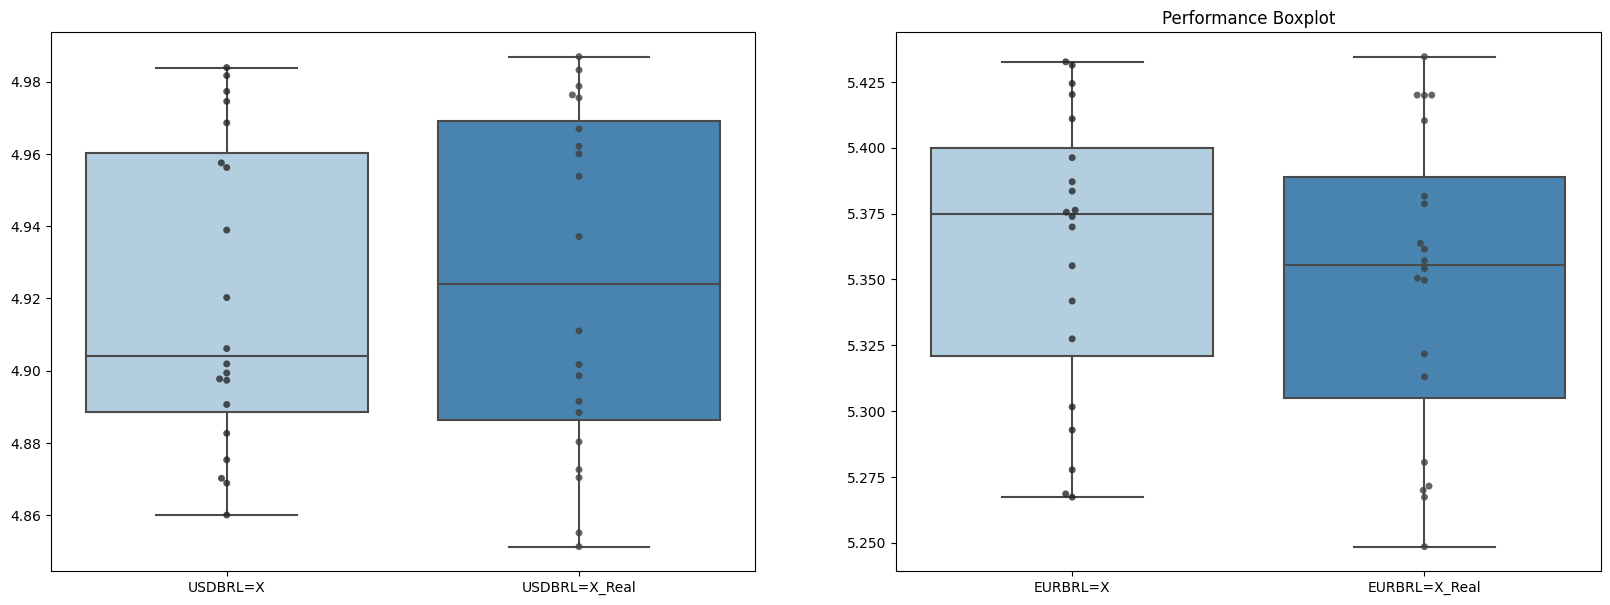

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7), nrows=1, ncols=2)
sns.boxplot(data=aval.filter(regex=usdbrl), dodge=False, palette="Blues", ax=ax[0])
sns.swarmplot(data=aval.filter(regex=usdbrl), color=".25", alpha=0.8, ax=ax[0])

sns.boxplot(data=aval.filter(regex=eurobrl), dodge=False, palette="Blues", ax=ax[1])
sns.swarmplot(data=aval.filter(regex=eurobrl), color=".25", alpha=0.8, ax=ax[1])

ax[1].set_title("Performance Boxplot")

### Performance

Figura predição por moeda

    EURBRL=X  EURBRL=X_Real  USDBRL=X  USDBRL=X_Real
0   5.373881         5.3615  4.890637         4.8986
1   5.375507         5.3787  4.897336         4.9017
2   5.383538         5.3571  4.901881         4.8915
3   5.376289         5.3541  4.897717         4.9110
4   5.369904         5.4103  4.906108         4.9621
5   5.396230         5.4346  4.938900         4.9832
6   5.424394         5.4200  4.968576         4.9869
7   5.431363         5.4200  4.983880         4.9755
8   5.432628         5.3816  4.981658         4.9669
9   5.410986         5.4199  4.974530         4.9787
10  5.420218         5.3505  4.977282         4.9371
11  5.387085         5.2715  4.956220         4.8551
12  5.327416         5.2673  4.899351         4.8803
13  5.292779         5.2485  4.882654         4.8704
14  5.267306         5.2699  4.870212         4.8726
15  5.268530         5.2805  4.868878         4.8513
16  5.277672         5.3130  4.860047         4.8884
17  5.301555         5.3637  4.875338         

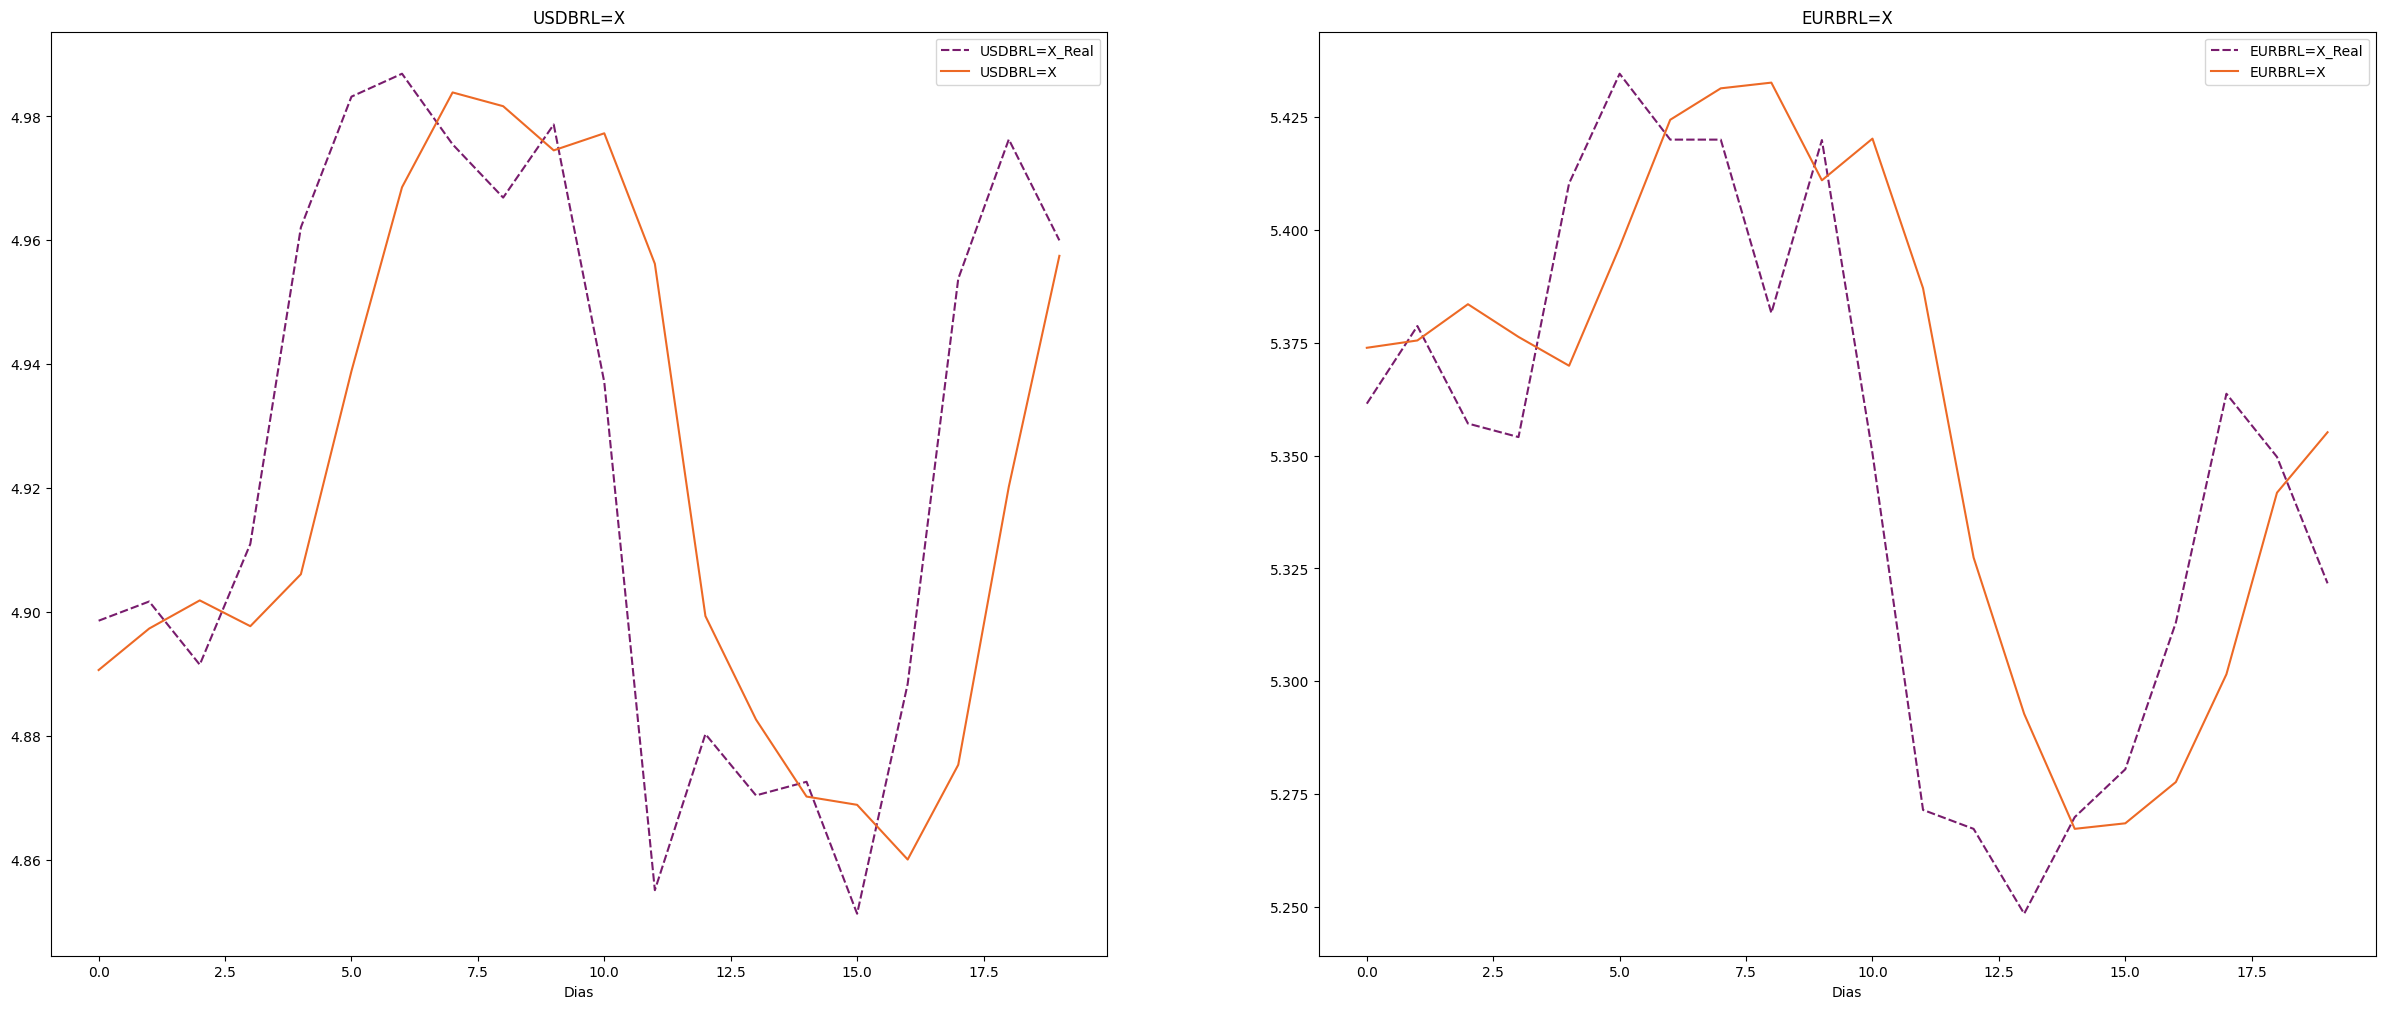

In [ ]:
def plot_aval(aval):
  fig, ax = plt.subplots(figsize=(30, 12), nrows=1, ncols=2)

  sns.lineplot(data=aval.filter(regex=usdbrl), palette="inferno", ax=ax[0], hue_order=[f'{usdbrl}_Real' ,usdbrl])
  ax[0].set_xlabel('Dias')
  ax[0].set_title(usdbrl)

  sns.lineplot(data=aval.filter(regex=eurobrl), palette="inferno", ax=ax[1], hue_order=[f'{eurobrl}_Real', eurobrl])
  ax[1].set_xlabel('Dias')
  ax[1].set_title(eurobrl)

plot_aval(aval)
print(aval)

## Avaliação no futuro


In [ ]:
aval_fut = pd.DataFrame()

sharpness = 0.03
test_fut_days = 20
for index, setup in result_all_best.iterrows():

  scaler, X_train, X_test, y_train, y_test = preprocess(df, setup['stock'], timesteps, test_fut_days)
  inittime = time()
  print(f"Usando {setup['stock']} com {setup['model_type']} , units={setup['unit']}, batch={setup['batch_size']}")
  # m, h = model_type(setup['model_type'], unit=setup['unit'], optimizer=setup['optimizer'], timesteps=timesteps,
  #                   X=X_train, y=y_train, epochs=epochs, batch_size=setup['batch_size'])

  m = tf.keras.models.load_model(f'mod_{setup["stock"]}')
  endtime = time()
  print(f'Tempo de treino: {(endtime-inittime)/60} minutos' )

  # Initial sequence for prediction
  initial_sequence = X_test[0]
  # Predict future values iteratively
  predicted_values = []

  for _ in range(test_fut_days):
    # Predict the next step
    next_step = m.predict(np.array([initial_sequence]))
    if sharpness is not None:
      next_step[0, 0] = next_step[0, 0] + next_step[0, 0]*uniform(-sharpness, sharpness)
    # Append the predicted value
    predicted_values.append(next_step[0, 0])
    # Update the initial sequence by removing the oldest value and appending the predicted value
    initial_sequence = np.roll(initial_sequence, shift=-1, axis=0)
    initial_sequence[-1] = next_step[0, 0]

  y_pred = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
  y_real = scaler.inverse_transform(y_test)
  aval_fut[f'{setup["stock"]}'] = y_pred[:,0]
  aval_fut[f'{setup["stock"]}_Real'] = y_real[:,0]



Usando EURBRL=X com LSTM_v1 , units=64, batch=16
Tempo de treino: 0.01252050797144572 minutos
1/1 [==============================] - 0s 23ms/step
Usando USDBRL=X com LSTM_v1 , units=128, batch=32
Tempo de treino: 0.012594187259674072 minutos
1/1 [==============================] - 0s 23ms/step


### Boxplot

Figura com boxplot e swarmplot para os melhores modelos

---

Text(0.5, 1.0, 'Performance Boxplot')

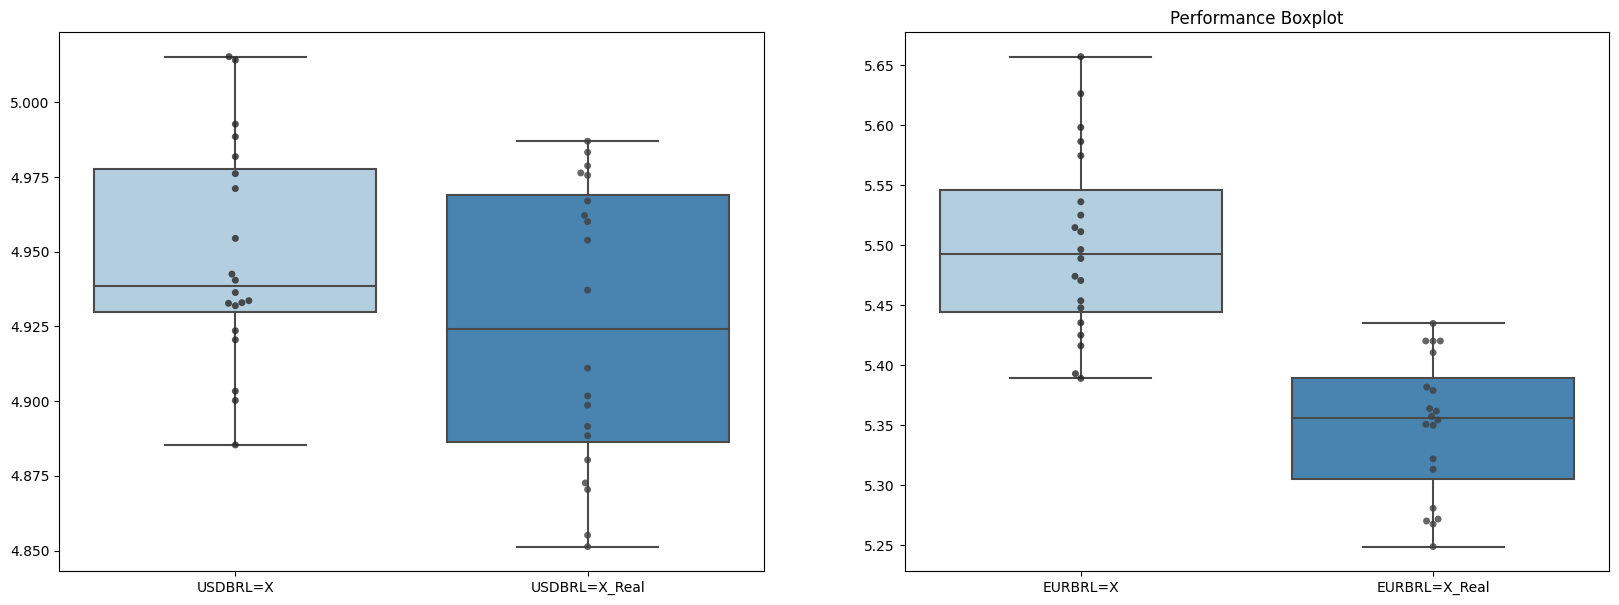

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7), nrows=1, ncols=2)
sns.boxplot(data=aval_fut.filter(regex=usdbrl), dodge=False, palette="Blues", ax=ax[0])
sns.swarmplot(data=aval_fut.filter(regex=usdbrl), color=".25", alpha=0.8, ax=ax[0])

sns.boxplot(data=aval_fut.filter(regex=eurobrl), dodge=False, palette="Blues", ax=ax[1])
sns.swarmplot(data=aval_fut.filter(regex=eurobrl), color=".25", alpha=0.8, ax=ax[1])

ax[1].set_title("Performance Boxplot")

### Performance

Figura predição por moeda

    EURBRL=X  EURBRL=X_Real  USDBRL=X  USDBRL=X_Real
0   5.415991         5.3615  4.942466         4.8986
1   5.453561         5.3787  4.903316         4.9017
2   5.424797         5.3571  4.936294         4.8915
3   5.392719         5.3541  4.920470         4.9110
4   5.435174         5.4103  4.932902         4.9621
5   5.388802         5.4346  4.931884         4.9832
6   5.447652         5.4200  4.885311         4.9869
7   5.470448         5.4200  4.923504         4.9755
8   5.496207         5.3816  4.954414         4.9669
9   5.511099         5.4199  4.900199         4.9787
10  5.473957         5.3505  4.971073         4.9371
11  5.514544         5.2715  4.988425         4.8551
12  5.488777         5.2673  5.015197         4.8803
13  5.536058         5.2485  5.014042         4.8704
14  5.574517         5.2699  4.976061         4.8726
15  5.524922         5.2805  4.981754         4.8513
16  5.598077         5.3130  4.932685         4.8884
17  5.626201         5.3637  4.992628         

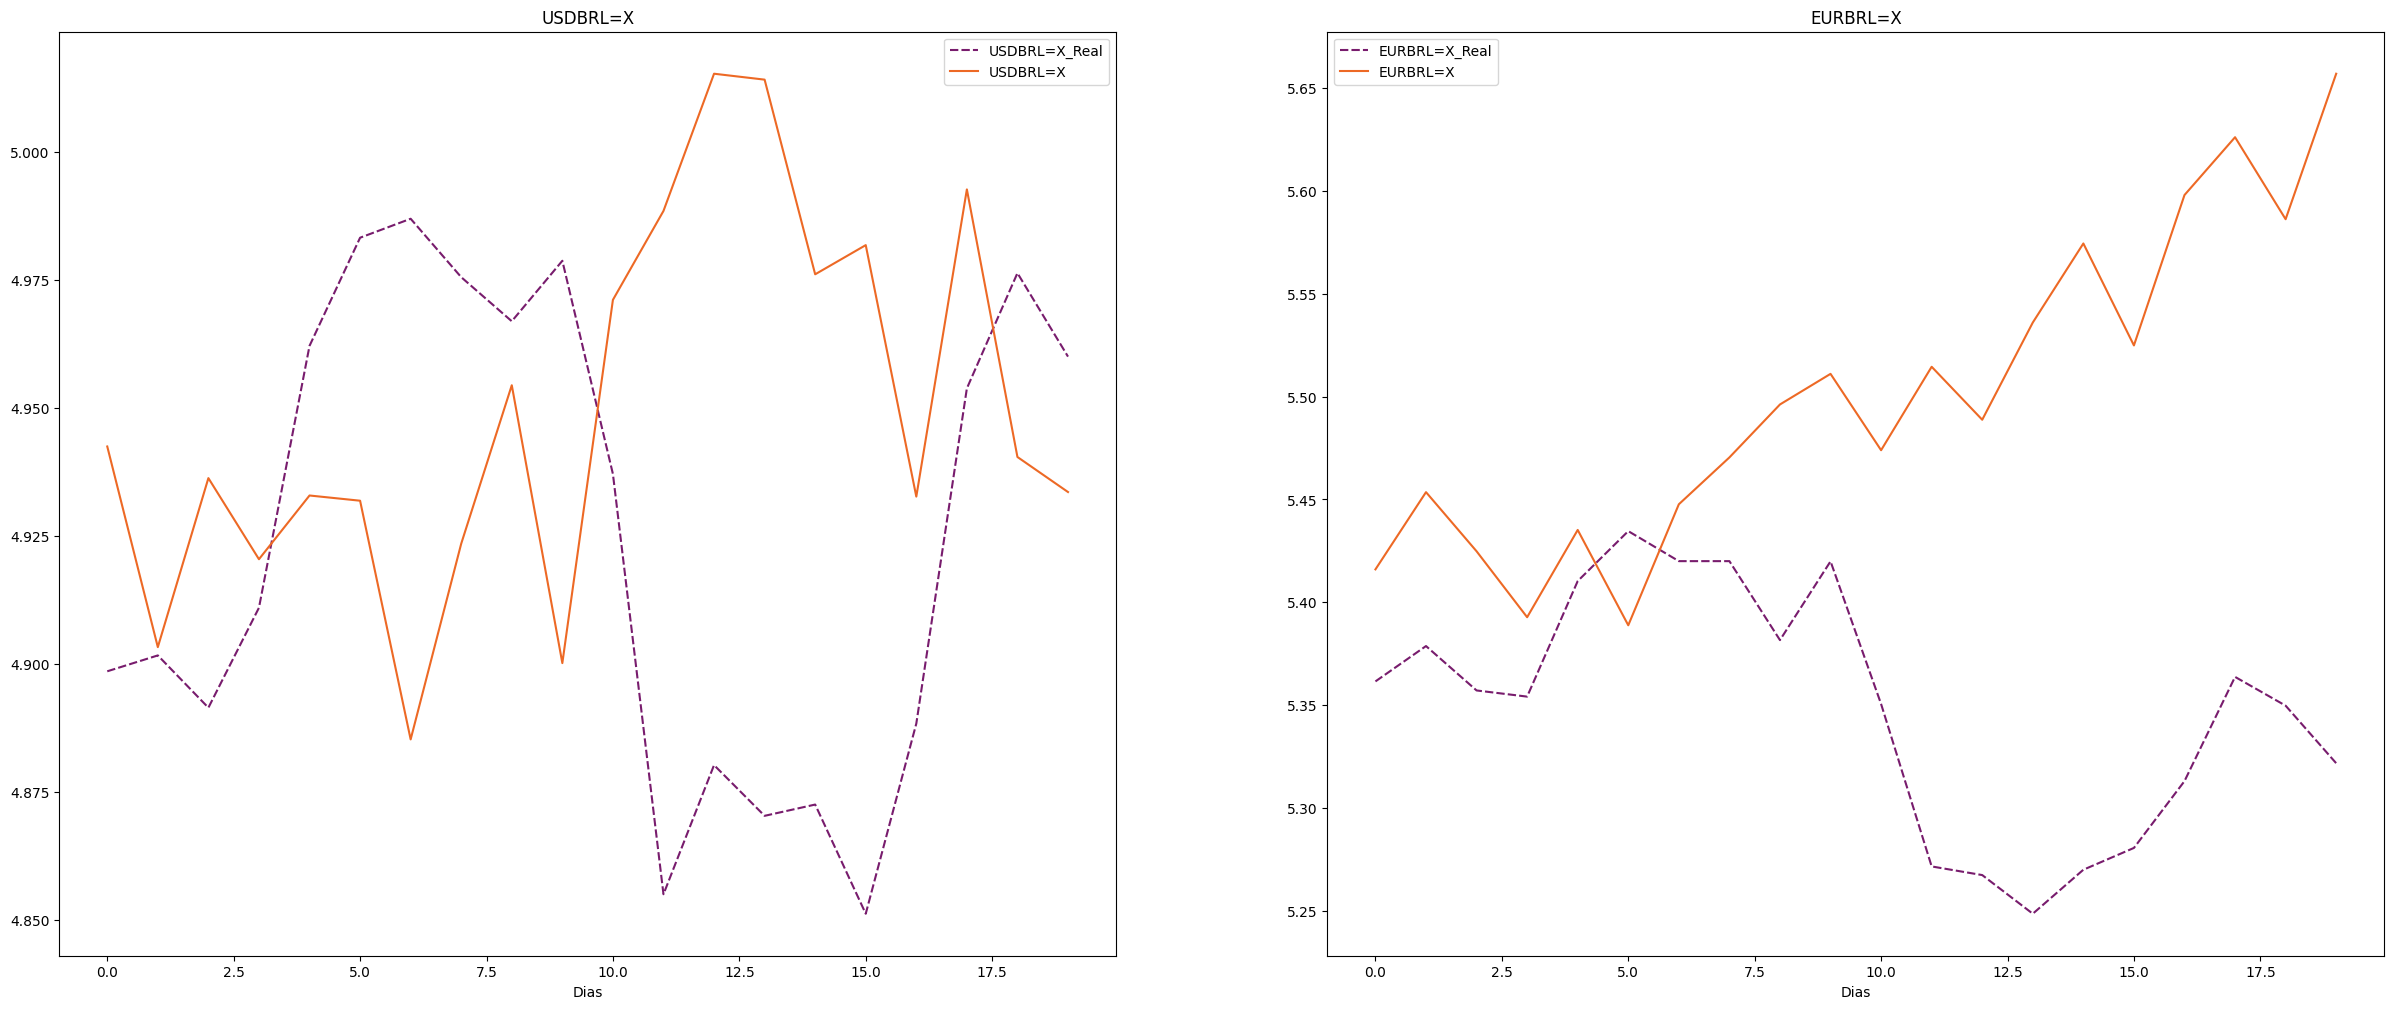

In [ ]:
plot_aval(aval_fut)
print(aval_fut)
aval_err = pd.DataFrame(columns=['EURBRL_bias', 'USDBRL_bias'])
aval_err['EURBRL_bias'] = 100*abs(aval_fut['EURBRL=X']-aval_fut['EURBRL=X_Real'])/aval_fut['EURBRL=X_Real']
aval_err['USDBRL_bias'] = 100*abs(aval_fut['USDBRL=X']-aval_fut['USDBRL=X_Real'])/aval_fut['USDBRL=X_Real']
print(aval_err)